# Project 3: Bermudan and American option pricing 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import time
from tqdm import tqdm


## Option Parameters

Parameters for the Bermudan option, including initial stock price, strike price, risk-free rate, volatility, and time to maturity as mentioned in the assignment.

In [2]:
S0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1.0

## Stock Price Dynamics:

The asset price at each node evolves as:
$$S_{i,j} = S_0 \cdot u^{i-j} \cdot d^j$$

where:
- $S_0$: Initial stock price.
- $u = e^{\sigma \sqrt{\Delta t}}$: Up factor.
- $d = e^{-\sigma \sqrt{\Delta t}} = 1/u$: Down factor.
- $\sigma$: Volatility.
- $\Delta t = T/N$: Time step size, with $T$ as maturity and $N$ as the number of steps.
- $i$: Time step index.
- $j$: Number of down moves up to step $i$.

## Risk-Neutral Probability:

The probability of an up move under the risk-neutral measure is:
$$p = \frac{e^{r \Delta t} - d}{u - d}$$

where $r$ is the risk-free rate, ensuring the expected asset price grows at the risk-free rate.

## Option Valuation:

For a Bermudan option, valuation proceeds via backward induction.

**At maturity ($i=N$):**
- Put payoff: $V_{N,j} = \max(K - S_{N,j}, 0)$
- Call payoff: $V_{N,j} = \max(S_{N,j} - K, 0)$

**At earlier steps ($i=N-1, \ldots, 0$), for each node $j$:**
- Continuation value: $C_{i,j} = e^{-r \Delta t} [p V_{i+1,j} + (1-p) V_{i+1,j+1}]$
- Exercise value: $E_{i,j} = \max(K - S_{i,j}, 0)$ (put) or $\max(S_{i,j} - K, 0)$ (call).
- Option value: $V_{i,j} = \max(E_{i,j}, C_{i,j})$ if $i$ corresponds to an exercise date; otherwise, $V_{i,j} = C_{i,j}$.

## Greeks:

**Delta ($\Delta$):** Measures sensitivity to the underlying price:
$$\Delta = \frac{V_{0,0} - V_{1,1}}{S_{0,0} - S_{1,1}}$$
Computed using the option values and stock prices at the first time step.

**Theta ($\Theta$):** Measures time decay:
$$\Theta = \frac{E[V_{t+\Delta t}] - V_{0,0}}{\Delta t}$$
Where $E[V_{t+\Delta t}] = p V_{0,1} + (1-p) V_{1,1}$ is the expected option value at $t+\Delta t$.

## A few more important notes:
( these are for the plots )
- **Exercise Strategy:** Visualizes the decision boundary where $E_{i,j} > C_{i,j}$, indicating regions where early exercise is optimal versus holding.
- **Exercise Boundary:** Plots the critical stock price at each exercise date below which (for puts) exercise is optimal, reflecting the trade-off between immediate payoff and continuation value.

In [3]:
class BinomialTreePricer:
    """
    Binomial Tree model for pricing Bermudan options.
    Can handle arbitrary exercise dates and compute option Greeks.
    """
    def __init__(self, S0=36, K=40, r=0.06, sigma=0.2, T=1, steps=50):
        """
        Initialize the binomial tree pricer with option parameters.
        
        Parameters:
        -----------
        S0 : float
            Initial stock price
        K : float
            Strike price
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        T : float
            Time to maturity in years
        steps : int
            Number of time steps in the binomial tree
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.steps = steps
        self.dt = T / steps
        
        # Calculate up and down factors
        self.u = np.exp(sigma * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # Risk-neutral probability
        self.discount = np.exp(-r * self.dt)
        
        # Store the stock price tree and option value tree
        self.stock_tree = None
        self.option_tree = None
        self.exercise_boundary = None
    
    def build_stock_tree(self):
        """
        Build the binomial tree of stock prices.
        """
        tree = np.zeros((self.steps + 1, self.steps + 1))
        
        # Initialize stock price at each node
        for i in range(self.steps + 1):
            for j in range(i + 1):
                tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        
        self.stock_tree = tree
        return tree
    
    def price_option(self, option_type='put', exercise_dates=None):
        """
        Price a Bermudan option using the binomial tree model.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times (in years) when exercise is allowed.
            If None, exercise is allowed at all time steps.
            
        Returns:
        --------
        float
            Option price
        """
        if self.stock_tree is None:
            self.build_stock_tree()
        
        # Initialize option value tree
        option_tree = np.zeros_like(self.stock_tree)
        exercise_boundary = np.zeros(self.steps + 1, dtype=bool)
        
        # Convert exercise dates to time step indices
        if exercise_dates is None:
            # Allow exercise at all time steps
            exercise_steps = list(range(self.steps + 1))
        else:
            # Map times to nearest time steps
            exercise_steps = [min(self.steps, max(0, round(t / self.dt))) for t in exercise_dates]
        
        # Terminal payoff at maturity
        for j in range(self.steps + 1):
            if option_type.lower() == 'call':
                option_tree[j, self.steps] = max(0, self.stock_tree[j, self.steps] - self.K)
            else:  # put
                option_tree[j, self.steps] = max(0, self.K - self.stock_tree[j, self.steps])
        
        # Backward induction
        for i in range(self.steps - 1, -1, -1):
            for j in range(i + 1):
                # Expected continuation value
                continuation = self.discount * (
                    self.p * option_tree[j, i + 1] + 
                    (1 - self.p) * option_tree[j + 1, i + 1]
                )
                
                # Immediate exercise value
                if option_type.lower() == 'call':
                    exercise = max(0, self.stock_tree[j, i] - self.K)
                else:  # put
                    exercise = max(0, self.K - self.stock_tree[j, i])
                
                # If we can exercise at this time step
                if i in exercise_steps:
                    option_tree[j, i] = max(continuation, exercise)
                    # Record if it's optimal to exercise
                    exercise_boundary[i] = exercise > continuation
                else:
                    option_tree[j, i] = continuation
        
        self.option_tree = option_tree
        self.exercise_boundary = exercise_boundary
        
        return option_tree[0, 0]
    
    def determine_exercise_strategy(self, option_type='put'):
        """
        Determine the optimal exercise strategy for a Bermudan option.
        
        Returns:
        --------
        numpy.ndarray
            Boolean mask where True indicates optimal to exercise
        """
        if self.option_tree is None:
            self.price_option(option_type)
            
        exercise_strategy = np.zeros_like(self.stock_tree, dtype=bool)
        
        # For each time step
        for i in range(self.steps):
            for j in range(i + 1):
                # Calculate continuation value
                continuation = self.discount * (
                    self.p * self.option_tree[j, i + 1] + 
                    (1 - self.p) * self.option_tree[j + 1, i + 1]
                )
                
                # Calculate exercise value
                if option_type.lower() == 'call':
                    exercise = max(0, self.stock_tree[j, i] - self.K)
                else:  # put
                    exercise = max(0, self.K - self.stock_tree[j, i])
                
                # Exercise is optimal if exercise value > continuation value
                exercise_strategy[j, i] = exercise > continuation
        
        return exercise_strategy
    
    def compute_greeks_numerical(self, option_type='put', exercise_dates=None, h=0.01):
        """
        Compute option Greeks numerically using a small step size.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times when exercise is allowed
        h : float
            Step size for numerical differentiation
            
        Returns:
        --------
        dict
            Dictionary containing delta and theta values
        """
        # Base price
        base_price = self.price_option(option_type, exercise_dates)
        
        # Delta: change in option price / change in stock price
        pricer_up = BinomialTreePricer(
            S0=self.S0 + h, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        price_up = pricer_up.price_option(option_type, exercise_dates)
        
        delta = (price_up - base_price) / h
        
        # Theta: change in option price / change in time (annualized)
        if self.T > h:
            pricer_less_time = BinomialTreePricer(
                S0=self.S0, K=self.K, r=self.r, 
                sigma=self.sigma, T=self.T - h, steps=self.steps
            )
            price_less_time = pricer_less_time.price_option(option_type, exercise_dates)
            theta = (price_less_time - base_price) / h
        else:
            theta = None  # Can't compute theta near expiry with this method
        
        return {'delta': delta, 'theta': theta}
    
    def compute_greeks_tree(self, option_type='put', exercise_dates=None):
        """
        Compute option Greeks using the binomial tree structure.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times when exercise is allowed
            
        Returns:
        --------
        dict
            Dictionary containing delta and theta values
        """
        # Ensure the option tree is built
        if self.option_tree is None:
            self.price_option(option_type, exercise_dates)
        
        # Delta at t=0: (V_{up} - V_{down}) / (S_{up} - S_{down})
        delta = (self.option_tree[0, 1] - self.option_tree[1, 1]) / (self.stock_tree[0, 1] - self.stock_tree[1, 1])
        
        # Theta at t=0: (V_{t+dt} - V_t) / dt
        # We approximate V_{t+dt} as the discounted expected value
        expected_next_value = self.p * self.option_tree[0, 1] + (1 - self.p) * self.option_tree[1, 1]
        theta = (expected_next_value - self.option_tree[0, 0]) / self.dt
        
        return {'delta': delta, 'theta': theta}
    
    def plot_option_tree(self, option_type='put', title=None):
        """
        Plot the option value tree.
        """
        if self.option_tree is None:
            self.price_option(option_type)
        
        plt.figure(figsize=(12, 8))
        
        # Create a mask for visualization where we only show valid points
        mask = np.ones_like(self.option_tree, dtype=bool)
        for i in range(self.steps + 1):
            for j in range(i + 1):
                mask[j, i] = False
        
        # Use seaborn for better visualization
        sns.heatmap(self.option_tree, mask=mask, annot=False, cmap='viridis', fmt='.2f')
        
        if title:
            plt.title(title)
        else:
            plt.title(f'Binomial Tree Option Values ({option_type.capitalize()})')
        
        plt.xlabel('Time Step')
        plt.ylabel('Stock Price Node')
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_stock_tree(self, option_type='put', title=None):
        """
        Plot the stock price tree.
        """
        if self.stock_tree is None:
            self.build_stock_tree()
        
        plt.figure(figsize=(12, 8))
        
        # Create a mask for visualization where we only show valid points
        mask = np.ones_like(self.stock_tree, dtype=bool)
        for i in range(self.steps + 1):
            for j in range(i + 1):
                mask[j, i] = False
        
        # Use seaborn for better visualization
        sns.heatmap(self.stock_tree, mask=mask, annot=False, cmap='Blues', fmt='.2f')
        
        if title:
            plt.title(title)
        else:
            plt.title('Binomial Tree Stock Prices')
        
        plt.xlabel('Time Step')
        plt.ylabel('Stock Price Node')
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_exercise_strategy(self, option_type='put'):
        """
        Plot the optimal exercise strategy.
        """
        strategy = self.determine_exercise_strategy(option_type)
        
        plt.figure(figsize=(12, 8))
        
        # Create a mask for visualization
        mask = np.ones_like(strategy, dtype=bool)
        for i in range(self.steps + 1):
            for j in range(i + 1):
                mask[j, i] = False
        
        # Create a custom colormap for exercise/hold visualization
        colors = [(0.2, 0.2, 0.9), (0.9, 0.2, 0.2)]  # Blue = hold, Red = exercise
        cmap_name = 'exercise_strategy'
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
        
        # Plot the exercise strategy
        sns.heatmap(strategy.astype(int), mask=mask, cmap=cm, 
                   annot=False, cbar_kws={'label': 'Exercise Strategy'})
        
        plt.title(f'Optimal Exercise Strategy for {option_type.capitalize()} Option')
        plt.xlabel('Time Step')
        plt.ylabel('Stock Price Node')
        
        # Add colorbar labels manually
        colorbar = plt.gcf().axes[1]
        colorbar.set_yticks([0.25, 0.75])
        colorbar.set_yticklabels(['Hold', 'Exercise'])
        
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_exercise_boundary(self, option_type='put'):
        """
        Plot the exercise boundary as a function of time and stock price.
        Shows the critical price at which exercise becomes optimal.
        """
        if self.stock_tree is None or self.option_tree is None:
            self.price_option(option_type)
        
        strategy = self.determine_exercise_strategy(option_type)
        
        # For each time step, find the critical stock price for exercise
        critical_prices = []
        time_steps = []
        
        for i in range(self.steps):
            exercise_nodes = []
            for j in range(i + 1):
                if strategy[j, i]:
                    exercise_nodes.append(self.stock_tree[j, i])
            
            if exercise_nodes:
                if option_type.lower() == 'call':
                    # For call, the critical price is the minimum price where exercise is optimal
                    critical_prices.append(min(exercise_nodes))
                else:
                    # For put, the critical price is the maximum price where exercise is optimal
                    critical_prices.append(max(exercise_nodes))
                time_steps.append(i * self.dt)
        
        plt.figure(figsize=(10, 6))
        
        if critical_prices:
            plt.plot(time_steps, critical_prices, 'r.-', linewidth=2)
            
            if option_type.lower() == 'call':
                plt.axhline(y=self.K, color='k', linestyle='--', label='Strike Price')
                plt.fill_between(time_steps, critical_prices, plt.ylim()[1], alpha=0.2, color='r', label='Exercise Region')
            else:
                plt.axhline(y=self.K, color='k', linestyle='--', label='Strike Price')
                plt.fill_between(time_steps, plt.ylim()[0], critical_prices, alpha=0.2, color='r', label='Exercise Region')
        
        plt.title(f'Exercise Boundary for {option_type.capitalize()} Option')
        plt.xlabel('Time (Years)')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        return plt.gcf()

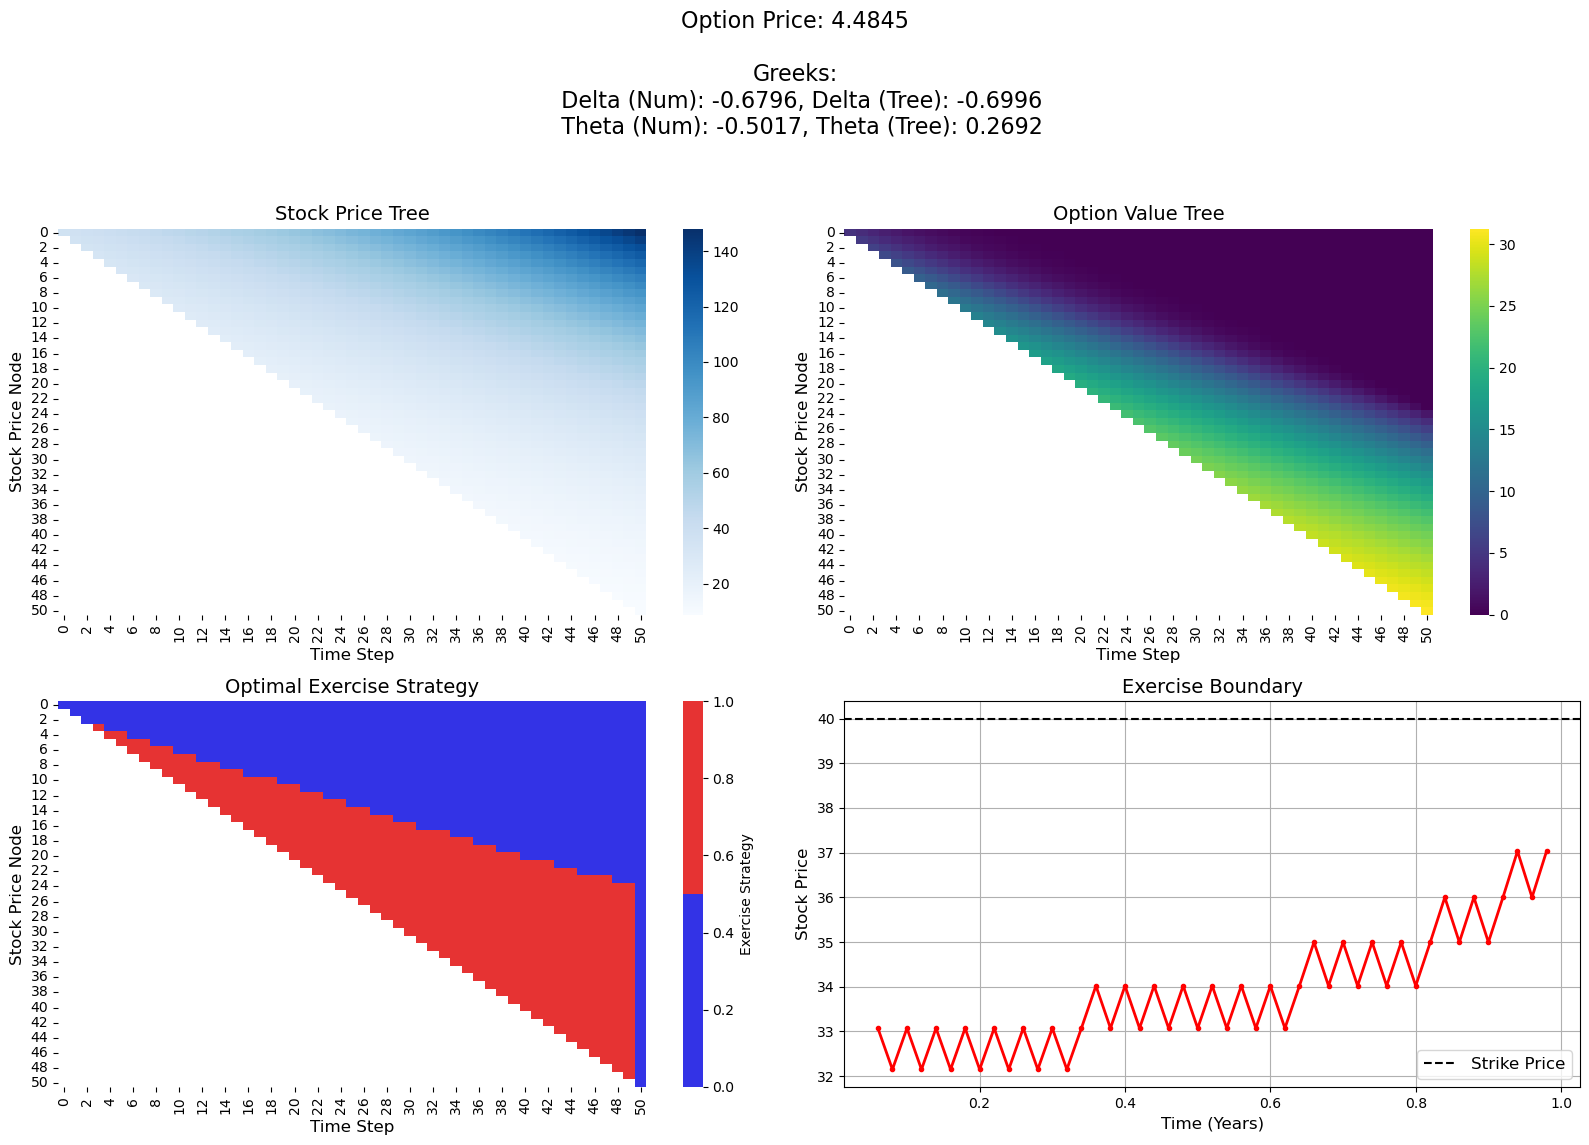

In [4]:
# Plots for binomial tree pricer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Assuming option_pricer and exercise_dates are already defined as in your notebook.
# For example:
steps = 50
exercise_dates = [i / steps for i in range(steps + 1)]
option_pricer = BinomialTreePricer(S0=S0, K=K, r=r, sigma=sigma, T=T, steps=steps)

def create_mask(steps, shape):
    """Create a mask for heatmap visualization."""
    mask = np.ones(shape, dtype=bool)
    for i in range(steps + 1):
        for j in range(i + 1):
            mask[j, i] = False
    return mask

# Ensure trees are built & compute option price and Greeks:
option_pricer.build_stock_tree()
option_price = option_pricer.price_option('put', exercise_dates)
greeks_numerical = option_pricer.compute_greeks_numerical('put', exercise_dates)
greeks_tree = option_pricer.compute_greeks_tree('put', exercise_dates)
strategy = option_pricer.determine_exercise_strategy('put')

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
title_text = (
    f"Option Price: {option_price:.4f}\n\n"
    f"Greeks:\n"
    f"  Delta (Num): {greeks_numerical['delta']:.4f}, Delta (Tree): {greeks_tree['delta']:.4f}\n"
    f"  Theta (Num): {greeks_numerical['theta']:.4f}, Theta (Tree): {greeks_tree['theta']:.4f}"
)
fig.suptitle(title_text, fontsize=16)  # Increased fontsize here

# Plot Stock Price Tree with colorbar
mask_stock = create_mask(option_pricer.steps, option_pricer.stock_tree.shape)
sns.heatmap(option_pricer.stock_tree, mask=mask_stock, ax=axs[0, 0],
            cmap='Blues', cbar=True, annot=False, fmt='.2f')
axs[0, 0].set_title("Stock Price Tree", fontsize=14)  # Increased fontsize here
axs[0, 0].set_xlabel("Time Step", fontsize=12)  # Increased fontsize here
axs[0, 0].set_ylabel("Stock Price Node", fontsize=12)  # Increased fontsize here

# Plot Option Value Tree with colorbar
mask_option = create_mask(option_pricer.steps, option_pricer.option_tree.shape)
sns.heatmap(option_pricer.option_tree, mask=mask_option, ax=axs[0, 1],
            cmap='viridis', cbar=True, annot=False, fmt='.2f')
axs[0, 1].set_title("Option Value Tree", fontsize=14)  # Increased fontsize here
axs[0, 1].set_xlabel("Time Step", fontsize=12)  # Increased fontsize here
axs[0, 1].set_ylabel("Stock Price Node", fontsize=12)  # Increased fontsize here

# Plot Exercise Strategy
colors = [(0.2, 0.2, 0.9), (0.9, 0.2, 0.2)]
cmap_strategy = LinearSegmentedColormap.from_list('exercise_strategy', colors, N=2)
mask_strategy = create_mask(option_pricer.steps, strategy.shape)
sns.heatmap(strategy.astype(int), mask=mask_strategy, ax=axs[1, 0],
            cmap=cmap_strategy, cbar_kws={'label': 'Exercise Strategy'}, annot=False)
axs[1, 0].set_title("Optimal Exercise Strategy", fontsize=14)  # Increased fontsize here
axs[1, 0].set_xlabel("Time Step", fontsize=12)  # Increased fontsize here
axs[1, 0].set_ylabel("Stock Price Node", fontsize=12)  # Increased fontsize here

# Plot Exercise Boundary
critical_prices = []
time_steps = []
for i in range(option_pricer.steps):
    exercise_nodes = []
    for j in range(i + 1):
        if strategy[j, i]:
            exercise_nodes.append(option_pricer.stock_tree[j, i])
    if exercise_nodes:
        critical_prices.append(max(exercise_nodes))
        time_steps.append(i * option_pricer.dt)

axs[1, 1].plot(time_steps, critical_prices, 'r.-', linewidth=2)
axs[1, 1].axhline(y=option_pricer.K, color='k', linestyle='--', label='Strike Price')
axs[1, 1].set_title("Exercise Boundary", fontsize=14)  # Increased fontsize here
axs[1, 1].set_xlabel("Time (Years)", fontsize=12)  # Increased fontsize here
axs[1, 1].set_ylabel("Stock Price", fontsize=12)  # Increased fontsize here
axs[1, 1].legend(fontsize=12)  # Increased fontsize here
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

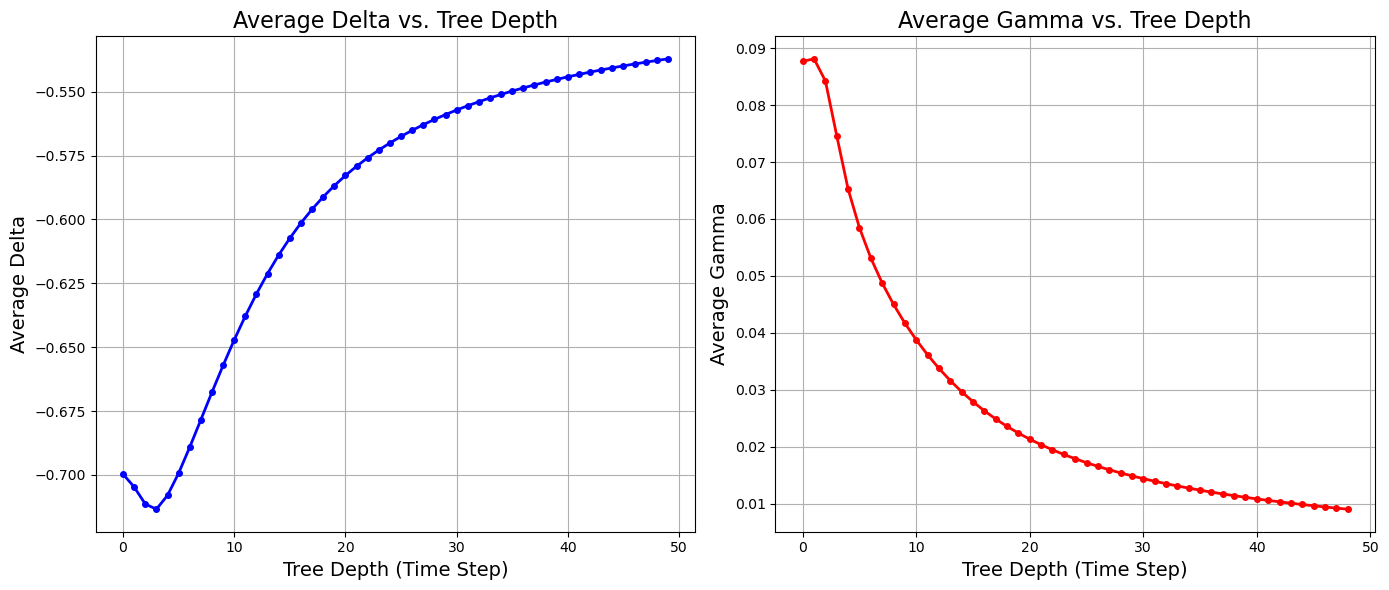

In [5]:
# To see how the greeks change with respect to tree depth 

# Instantiate the BinomialTreePricer (assuming the class definition is already available)
option_pricer = BinomialTreePricer(S0=S0, K=K, r=r, sigma=sigma, T=T, steps=steps)

# Build the stock tree and compute the option value tree
option_pricer.build_stock_tree()
option_pricer.price_option('put')

# Calculate local deltas at each node (except at maturity)
# Delta at node (j,i) is approximated as:
#    delta = (V(j, i+1) - V(j+1, i+1)) / (S(j, i+1) - S(j+1, i+1))
local_delta = np.full((steps, steps), np.nan)
for i in range(steps):
    for j in range(i + 1):
        # Use children at time step i+1
        V_up = option_pricer.option_tree[j, i + 1]
        V_down = option_pricer.option_tree[j + 1, i + 1]
        S_up = option_pricer.stock_tree[j, i + 1]
        S_down = option_pricer.stock_tree[j + 1, i + 1]
        local_delta[i, j] = (V_up - V_down) / (S_up - S_down)

# Calculate local gammas at each node where possible (nodes that have two layers below)
# Gamma at node (j,i) is approximated as:
#    gamma = (delta_up - delta_down) / (S(j, i+1) - S(j+1, i+1))
local_gamma = np.full((steps - 1, steps), np.nan)
for i in range(steps - 1):
    for j in range(i + 1):
        delta_up = local_delta[i + 1, j]
        delta_down = local_delta[i + 1, j + 1]
        # The denominator is the same as for the delta calculation at the parent node
        S_up = option_pricer.stock_tree[j, i + 1]
        S_down = option_pricer.stock_tree[j + 1, i + 1]
        local_gamma[i, j] = (delta_up - delta_down) / (S_up - S_down)

# Compute average delta and gamma at each tree depth
avg_delta = []
for i in range(steps):
    # Only consider the valid nodes (first i+1 nodes)
    avg_delta.append(np.nanmean(local_delta[i, :i + 1]))
    
avg_gamma = []
# Gamma can only be computed up to depth steps-2 (since it requires two levels below)
for i in range(steps - 1):
    avg_gamma.append(np.nanmean(local_gamma[i, :i + 1]))

tree_depths_delta = np.arange(steps)  # 0 to steps-1 for delta
tree_depths_gamma = np.arange(steps - 1)  # 0 to steps-2 for gamma

# Create subplots for delta and gamma vs. tree depth
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Average Delta vs. Tree Depth
axs[0].plot(tree_depths_delta, avg_delta, 'b.-', linewidth=2, markersize=8)
axs[0].set_title("Average Delta vs. Tree Depth", fontsize=16)
axs[0].set_xlabel("Tree Depth (Time Step)", fontsize=14)
axs[0].set_ylabel("Average Delta", fontsize=14)
axs[0].grid(True)

# Plot Average Gamma vs. Tree Depth
axs[1].plot(tree_depths_gamma, avg_gamma, 'r.-', linewidth=2, markersize=8)
axs[1].set_title("Average Gamma vs. Tree Depth", fontsize=16)
axs[1].set_xlabel("Tree Depth (Time Step)", fontsize=14)
axs[1].set_ylabel("Average Gamma", fontsize=14)
axs[1].grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3156491/412052117.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


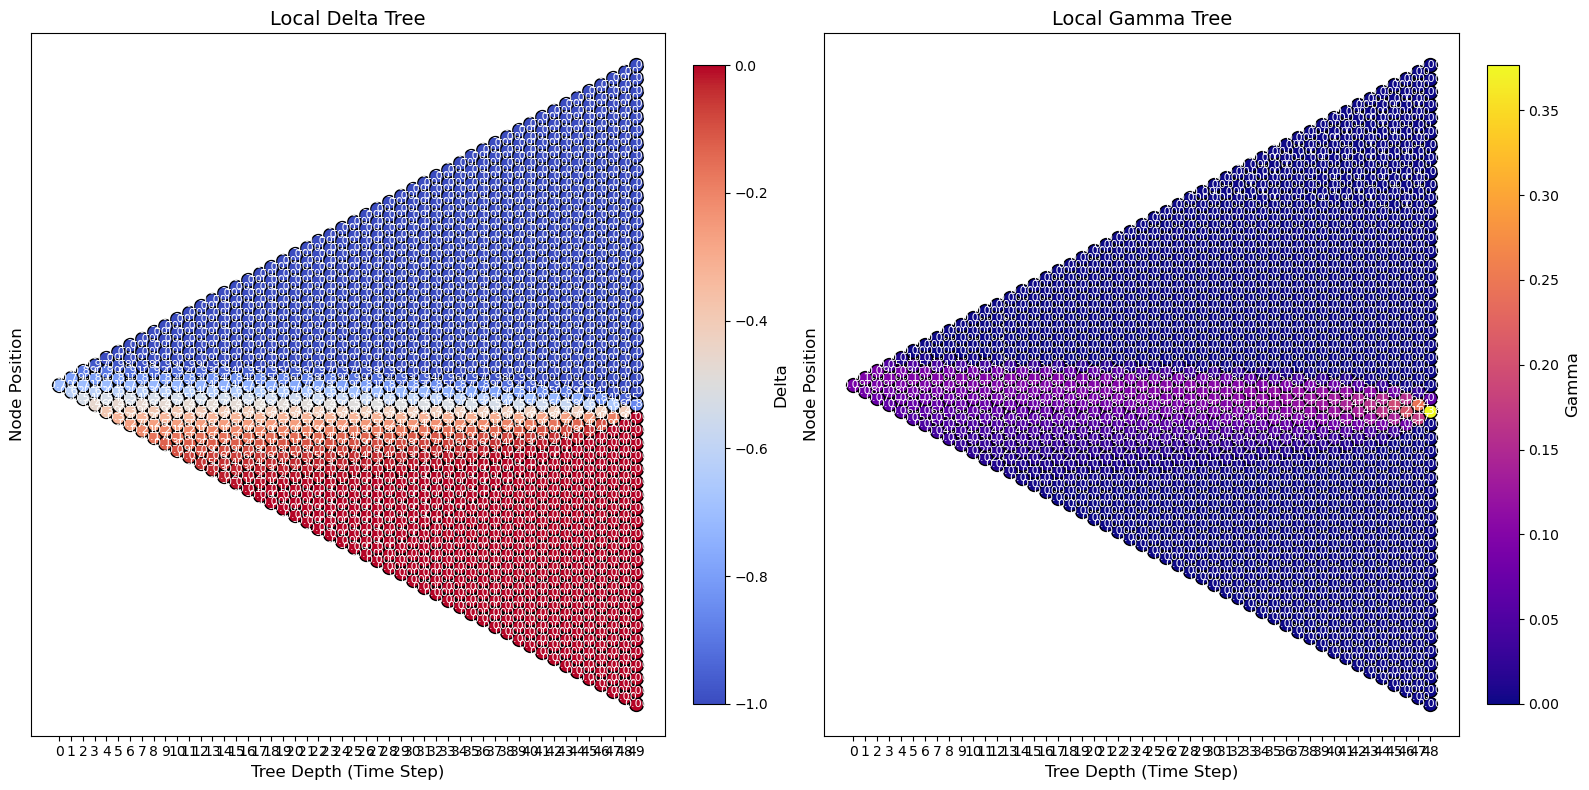

In [6]:

import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
# --- Compute Local Greeks ---
# Note: For local delta, we compute at each node (except at maturity)
# Delta at node (j, i) (for i=0 to steps-1, j=0 to i) is approximated as:
#    delta = (V[j, i+1] - V[j+1, i+1]) / (S[j, i+1] - S[j+1, i+1])
steps = option_pricer.steps  # original tree steps

# Create a local delta tree with shape (steps, steps)
local_delta = np.full((steps, steps), np.nan)
for i in range(steps):
    for j in range(i + 1):
        S_up = option_pricer.stock_tree[j, i+1]
        S_down = option_pricer.stock_tree[j+1, i+1]
        V_up = option_pricer.option_tree[j, i+1]
        V_down = option_pricer.option_tree[j+1, i+1]
        local_delta[i, j] = (V_up - V_down) / (S_up - S_down)

# For gamma, we need the delta differences.
# Gamma at node (j, i) (for i=0 to steps-2, j=0 to i) is approximated as:
#    gamma = (delta[j, i+1] - delta[j+1, i+1]) / (S[j, i+1] - S[j+1, i+1])
local_gamma = np.full((steps - 1, steps), np.nan)
for i in range(steps - 1):
    for j in range(i + 1):
        delta_up = local_delta[i+1, j]
        delta_down = local_delta[i+1, j+1]
        S_up = option_pricer.stock_tree[j, i+1]
        S_down = option_pricer.stock_tree[j+1, i+1]
        local_gamma[i, j] = (delta_up - delta_down) / (S_up - S_down)

# --- Define a Generic Plot Function for Greek Trees ---
def plot_greek_tree_gradient_ax(ax, tree, num_steps, title="Greek Tree", value_label="Value", cmap_name='viridis'):
    """
    Plot a triangular tree (for Greeks) in a tree-like structure with a color gradient.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axis on which to plot.
    tree : numpy.ndarray
        2D array of shape (num_steps, num_steps) (or similar) where row i contains i+1 valid entries.
    num_steps : int
        Number of time steps (levels) to plot.
    title : str
        Title for the plot.
    value_label : str
        Label for the colorbar.
    cmap_name : str
        Name of the colormap.
    
    Returns:
    --------
    norm, cmap : normalization and colormap objects (for creating a colorbar)
    """
    cmap = cm.get_cmap(cmap_name)
    norm = Normalize(vmin=np.nanmin(tree), vmax=np.nanmax(tree))
    
    for i in range(num_steps):
        for j in range(i + 1):
            x = i
            y = j - i / 2.0  # center nodes vertically
            value = tree[i, j]
            node_color = cmap(norm(value))
            
            # Plot node as a circle
            ax.scatter(x, y, s=100, color=node_color, edgecolor='k', zorder=3)
            # Annotate the node with its value (rounded)
            ax.text(x, y, f"{value:.2f}", ha='center', va='center',
                    fontsize=8, zorder=4, color='white')
            
            # Draw lines to children if not at the last level
            if i < num_steps - 1:
                child_x = i + 1
                child_y_left = j - (i + 1) / 2.0
                child_y_right = (j + 1) - (i + 1) / 2.0
                ax.plot([x, child_x], [y, child_y_left], 'k-', lw=0.5, zorder=1)
                ax.plot([x, child_x], [y, child_y_right], 'k-', lw=0.5, zorder=1)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Tree Depth (Time Step)", fontsize=12)
    ax.set_ylabel("Node Position", fontsize=12)
    ax.set_xticks(range(num_steps))
    ax.set_yticks([])
    
    return norm, cmap

# --- Plotting the Greek Trees ---
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the Delta Tree
# local_delta has shape (steps, steps) and valid levels 0 to steps-1.
norm_delta, cmap_delta = plot_greek_tree_gradient_ax(axs[0], local_delta, num_steps=steps,
                                                     title="Local Delta Tree", value_label="Delta", cmap_name='coolwarm')
sm_delta = ScalarMappable(norm=norm_delta, cmap=cmap_delta)
sm_delta.set_array([])
cbar_delta = fig.colorbar(sm_delta, ax=axs[0], fraction=0.046, pad=0.04)
cbar_delta.set_label("Delta", fontsize=12)

# Plot the Gamma Tree
# local_gamma has shape (steps-1, steps) and valid levels 0 to steps-2.
norm_gamma, cmap_gamma = plot_greek_tree_gradient_ax(axs[1], local_gamma, num_steps=steps - 1,
                                                     title="Local Gamma Tree", value_label="Gamma", cmap_name='plasma')
sm_gamma = ScalarMappable(norm=norm_gamma, cmap=cmap_gamma)
sm_gamma.set_array([])
cbar_gamma = fig.colorbar(sm_gamma, ax=axs[1], fraction=0.046, pad=0.04)
cbar_gamma.set_label("Gamma", fontsize=12)

plt.tight_layout()
plt.show()


## American Option Pricing

An American option allows exercise at any time up to maturity, unlike a Bermudan option with discrete exercise dates. The Binomial Tree method prices it by permitting exercise at every step, serving as an upper bound to Bermudan prices as the number of exercise opportunities increases.

### Valuation:

At each node:
- Continuation value:
  $$C_{i,j} = e^{-r \Delta t} [p V_{i+1,j} + (1-p) V_{i+1,j+1}]$$
- Exercise value:
  $$E_{i,j} = \max(K - S_{i,j}, 0) \quad \text{(put)}$$
- Option value:
  $$V_{i,j} = \max(E_{i,j}, C_{i,j})$$

With large $N$, this approximates the continuous-time American option price.

### Relation to Bermudan:

As the number of exercise dates $N_e \to \infty$ in a Bermudan option, its price converges to the American price:
$$V_{\text{Bermudan}}(N_e) \to V_{\text{American}}$$

**Exercise Boundary:** Shows the critical stock price over time where exercise becomes optimal, typically lower than the strike for puts due to the continuous exercise feature.

In [7]:
class AmericanOptionPricer:
    """
    Price American options by using Bermudan options
    with a large number of exercise dates.
    """
    def __init__(self, S0=36, K=40, r=0.06, sigma=0.2, T=1, steps=50):
        """
        Initialize with option parameters.
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.steps = steps
    
    def price(self, option_type='put'):
        """
        Price an American option by using the binomial tree
        with exercise allowed at every time step.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
            
        Returns:
        --------
        float
            Option price
        """
        pricer = BinomialTreePricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        
        # Allow exercise at every time step
        return pricer.price_option(option_type)
    
    def price_as_bermudan(self, option_type='put', num_exercise_dates=50):
        """
        Price an American option by approximating it as a Bermudan option
        with a specified number of equally spaced exercise dates.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        num_exercise_dates : int
            Number of exercise dates
            
        Returns:
        --------
        float
            Option price
        """
        pricer = BinomialTreePricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        
        # Create equally spaced exercise dates
        exercise_dates = np.linspace(0, self.T, num_exercise_dates + 1)[1:]
        
        return pricer.price_option(option_type, exercise_dates)
    
    def compute_greeks(self, option_type='put', method='tree'):
        """
        Compute Greeks for American option using chosen method.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        method : str
            'tree' or 'numerical'
            
        Returns:
        --------
        dict
            Dictionary containing Greeks
        """
        pricer = BinomialTreePricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        
        if method == 'tree':
            return pricer.compute_greeks_tree(option_type)
        else:  # numerical
            return pricer.compute_greeks_numerical(option_type)
    
    def plot_exercise_strategy(self, option_type='put'):
        """
        Plot the optimal exercise strategy for American option.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
            
        Returns:
        --------
        matplotlib.figure.Figure
            The figure with the plot
        """
        pricer = BinomialTreePricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        
        # Price the option first to build the tree
        pricer.price_option(option_type)
        
        return pricer.plot_exercise_strategy(option_type)
    
    def plot_exercise_boundary(self, option_type='put'):
        """
        Plot the exercise boundary for American option.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
            
        Returns:
        --------
        matplotlib.figure.Figure
            The figure with the plot
        """
        pricer = BinomialTreePricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        
        # Price the option first to build the tree
        pricer.price_option(option_type)
        
        return pricer.plot_exercise_boundary(option_type)

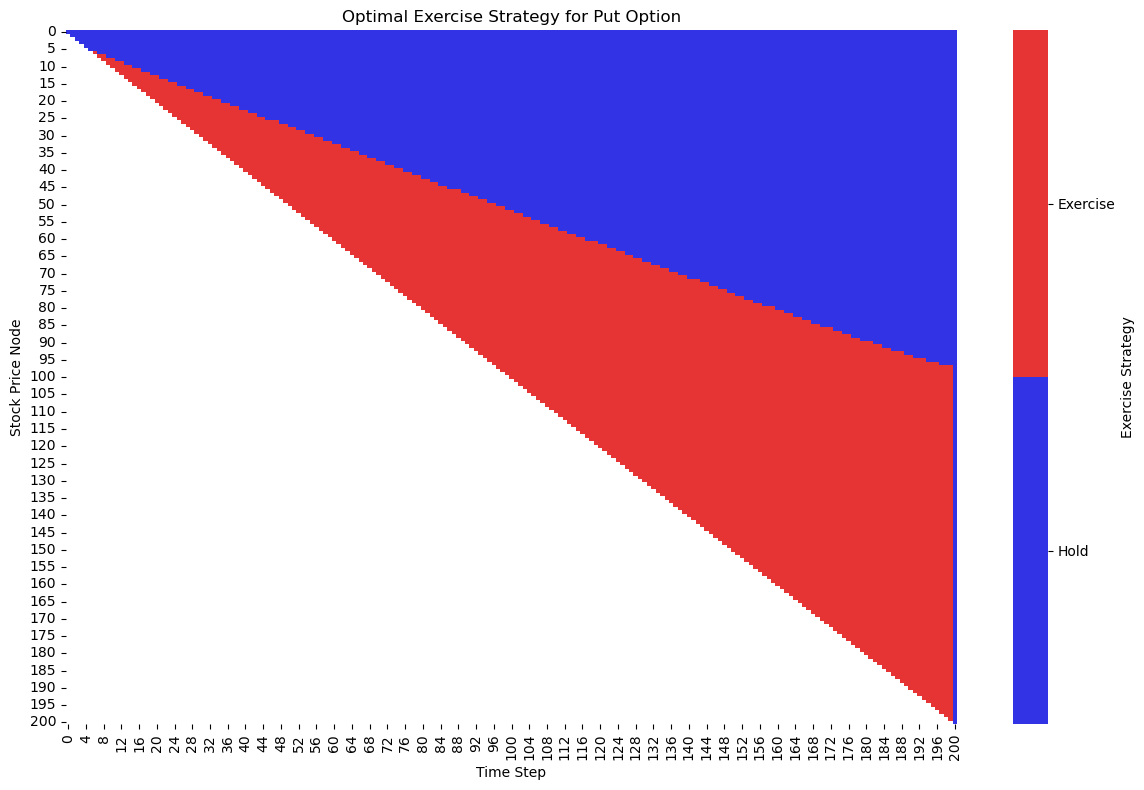

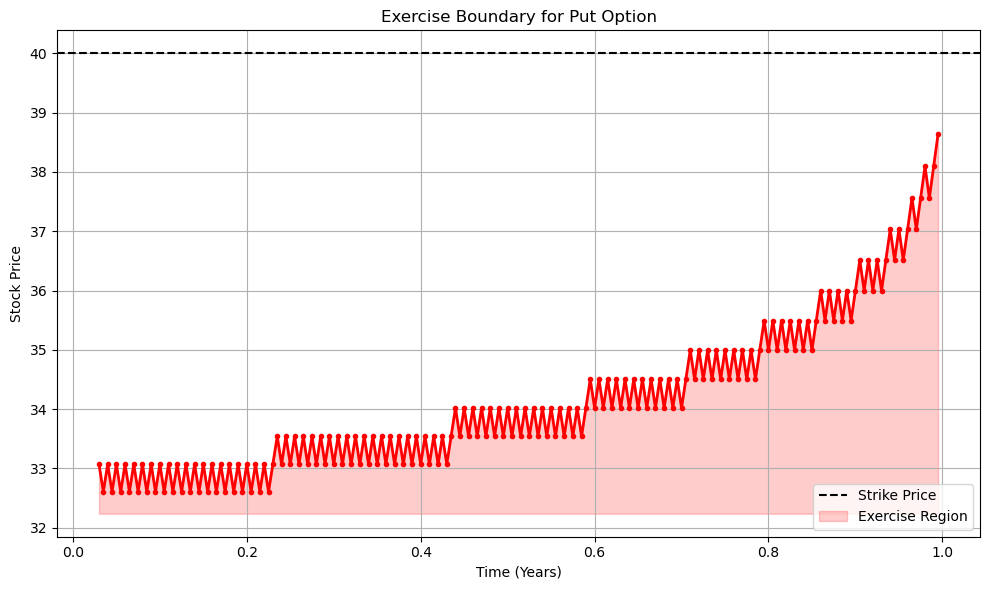

American Option Price: 4.4871

Greeks (Tree):
  Delta: -0.6972
  Theta: 0.2693

Greeks (Numerical):
  Delta: -0.6913
  Theta: -0.4845


In [8]:
american_pricer = AmericanOptionPricer(S0=S0, K=K, r=r, sigma=sigma, T=T, steps=200)
american_price = american_pricer.price('put')
greeks_american_tree = american_pricer.compute_greeks('put', method='tree')
greeks_american_numerical = american_pricer.compute_greeks('put', method='numerical')

# Plot Exercise Strategy
exercise_strategy_american = american_pricer.plot_exercise_strategy('put')
plt.show() # Show the first plot

# Plot Exercise Boundary
exercise_boundary_american = american_pricer.plot_exercise_boundary('put')
plt.show() # Show the second plot

# Print the information neatly
print(f"American Option Price: {american_price:.4f}\n")

print("Greeks (Tree):")
print(f"  Delta: {greeks_american_tree['delta']:.4f}")
print(f"  Theta: {greeks_american_tree['theta']:.4f}\n")

print("Greeks (Numerical):")
print(f"  Delta: {greeks_american_numerical['delta']:.4f}")
print(f"  Theta: {greeks_american_numerical['theta']:.4f}")

## Bermudan to American Option Price Convergence

Convergence analysis examines how the Binomial Tree method approximates the true option price as the number of time steps increases. The binomial model converges to the continuous Black-Scholes model as $N \to \infty$, with the error decreasing as $O(1/N)$.

### Price Convergence:

The option price $V(N)$ for $N$ steps approaches the true price $V^*$:
$$V(N) = V^* + \frac{c_1}{N} + \frac{c_2}{N^2} + \cdots$$

Where $c_1, c_2, \ldots$ are constants, and the leading error term is $O(1/N)$.

### Error Analysis:

- **Absolute error:** $|V(N) - V^*|$
- **Relative error:** $\frac{|V(N) - V^*|}{V^*}$

A reference price (e.g., computed with large $N$) estimates $V^*$.

**Step Convergence:** Displays option price versus number of steps, showing stabilization as $N$ increases, indicating numerical convergence to the true price.
**Price Error:** Plots absolute and relative errors, typically on a log scale, revealing the rate of convergence (e.g., linear in $1/N$).

We see how Bermudan option prices converge to the American option price as the number of exercise dates increases. The Bermudan price lies between the European (exercise only at maturity) and American prices, approaching the latter with more frequent exercise opportunities.

### Price Dependence:

For $N_e$ exercise dates:
$$V_{\text{European}} \leq V_{\text{Bermudan}}(N_e) \leq V_{\text{American}}$$

As $N_e$ increases, the discretization error diminishes, and $V_{\text{Bermudan}}$ approximates $V_{\text{American}}$.

**Exercise Dates Convergence:** Plots price versus number of exercise dates, showing convergence to the American price, with a reference line indicating the limiting value.

In [9]:
class ConvergenceAnalyzer:
    """
    Analyze the convergence of Bermudan option pricing
    with increasing number of time steps.
    """
    def __init__(self, S0=36, K=40, r=0.06, sigma=0.2, T=1):
        """
        Initialize with option parameters.
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
    
    def analyze_step_convergence(self, option_type='put', exercise_dates=None, 
                              min_steps=10, max_steps=500, step_increment=10):
        """
        Analyze how the option price converges with increasing number of time steps.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times when exercise is allowed
        min_steps : int
            Minimum number of time steps to consider
        max_steps : int
            Maximum number of time steps to consider
        step_increment : int
            Increment in number of steps between each pricing
            
        Returns:
        --------
        tuple
            (steps_list, prices, computation_times)
        """
        steps_list = range(min_steps, max_steps + 1, step_increment)
        prices = []
        computation_times = []
        
        for steps in tqdm(steps_list, desc="Analyzing step convergence"):
            start_time = time.time()
            
            pricer = BinomialTreePricer(
                S0=self.S0, K=self.K, r=self.r, 
                sigma=self.sigma, T=self.T, steps=steps
            )
            
            price = pricer.price_option(option_type, exercise_dates)
            elapsed_time = time.time() - start_time
            
            prices.append(price)
            computation_times.append(elapsed_time)
        
        return list(steps_list), prices, computation_times
    
    def plot_step_convergence(self, option_type='put', exercise_dates=None, 
                           min_steps=10, max_steps=500, step_increment=10,
                           reference_price=None):
        """
        Plot the convergence of option price with increasing number of time steps.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times when exercise is allowed
        min_steps, max_steps, step_increment : int
            Parameters for step sizes to consider
        reference_price : float or None
            Reference price to plot as horizontal line (if known)
            
        Returns:
        --------
        tuple
            (fig, steps_list, prices, computation_times)
        """
        steps, prices, times = self.analyze_step_convergence(
            option_type, exercise_dates, min_steps, max_steps, step_increment
        )
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot price convergence
        ax1.plot(steps, prices, 'b.-')
        ax1.set_title(f'Price Convergence with Number of Steps ({option_type.capitalize()} option)')
        ax1.set_xlabel('Number of Steps')
        ax1.set_ylabel('Option Price')
        ax1.grid(True)
        
        # Add reference price line if provided
        if reference_price is not None:
            ax1.axhline(y=reference_price, color='r', linestyle='--', 
                       label=f'Reference Price: {reference_price:.4f}')
            ax1.legend()
        
        # Plot computation time
        ax2.plot(steps, times, 'g.-')
        ax2.set_title('Computation Time vs. Number of Steps')
        ax2.set_xlabel('Number of Steps')
        ax2.set_ylabel('Computation Time (seconds)')
        ax2.grid(True)
        
        plt.tight_layout()
        
        return fig, steps, prices, times
    
    def plot_price_error(self, option_type='put', exercise_dates=None, 
                      min_steps=10, max_steps=500, step_increment=10,
                      reference_price=None):
        """
        Plot the error in option price with respect to a reference price.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times when exercise is allowed
        min_steps, max_steps, step_increment : int
            Parameters for step sizes to consider
        reference_price : float
            Reference price to calculate error against
            
        Returns:
        --------
        tuple
            (fig, steps_list, relative_errors)
        """
        if reference_price is None:
            # Use a large number of steps to compute a reference price
            ref_pricer = BinomialTreePricer(
                S0=self.S0, K=self.K, r=self.r, 
                sigma=self.sigma, T=self.T, steps=1000
            )
            reference_price = ref_pricer.price_option(option_type, exercise_dates)
            print(f"Using computed reference price: {reference_price:.6f}")
        
        steps, prices, _ = self.analyze_step_convergence(
            option_type, exercise_dates, min_steps, max_steps, step_increment
        )
        
        # Calculate absolute and relative errors
        abs_errors = [abs(p - reference_price) for p in prices]
        rel_errors = [abs(p - reference_price) / reference_price * 100 for p in prices]
        
        # Create plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot absolute error
        ax1.plot(steps, abs_errors, 'b.-')
        ax1.set_title(f'Absolute Error vs. Number of Steps ({option_type.capitalize()} option)')
        ax1.set_xlabel('Number of Steps')
        ax1.set_ylabel('Absolute Error')
        ax1.set_yscale('log')  # Log scale often better for error analysis
        ax1.grid(True)
        
        # Plot relative error
        ax2.plot(steps, rel_errors, 'r.-')
        ax2.set_title('Relative Error (%) vs. Number of Steps')
        ax2.set_xlabel('Number of Steps')
        ax2.set_ylabel('Relative Error (%)')
        ax2.set_yscale('log')
        ax2.grid(True)
        
        plt.tight_layout()
        
        return fig, steps, rel_errors
    
    def find_steps_for_convergence(self, option_type='put', exercise_dates=None, 
                                tolerance=0.001, max_steps=1000, step_increment=5):
        """
        Find the minimum number of steps needed to achieve a specified tolerance.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        exercise_dates : list or None
            List of times when exercise is allowed
        tolerance : float
            Relative tolerance for convergence
        max_steps : int
            Maximum number of steps to consider
        step_increment : int
            Increment in number of steps between each pricing
            
        Returns:
        --------
        int
            Minimum number of steps needed for convergence
        """
        # First, compute a reference price with a very large number of steps
        ref_pricer = BinomialTreePricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=max_steps*2
        )
        reference_price = ref_pricer.price_option(option_type, exercise_dates)
        
        for steps in range(10, max_steps + 1, step_increment):
            pricer = BinomialTreePricer(
                S0=self.S0, K=self.K, r=self.r, 
                sigma=self.sigma, T=self.T, steps=steps
            )
            price = pricer.price_option(option_type, exercise_dates)
            
            relative_error = abs(price - reference_price) / reference_price
            
            if relative_error < tolerance:
                return steps
        
        return max_steps  # Could not achieve specified tolerance



class BermudanExerciseDatesAnalyzer:
    """
    Analyze the convergence of Bermudan option pricing
    with increasing number of exercise dates.
    """
    def __init__(self, S0=36, K=40, r=0.06, sigma=0.2, T=1, steps=100):
        """
        Initialize with option parameters.
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.steps = steps
    
    def analyze_exercise_dates_convergence(self, option_type='put', 
                                        min_dates=1, max_dates=100, date_increment=1):
        """
        Analyze how the option price converges with increasing number of exercise dates.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        min_dates : int
            Minimum number of exercise dates to consider
        max_dates : int
            Maximum number of exercise dates to consider
        date_increment : int
            Increment in number of exercise dates between each pricing
            
        Returns:
        --------
        tuple
            (dates_list, prices, computation_times)
        """
        dates_list = range(min_dates, max_dates + 1, date_increment)
        prices = []
        computation_times = []
        
        for num_dates in tqdm(dates_list, desc="Analyzing exercise dates convergence"):
            start_time = time.time()
            
            # Create equally spaced exercise dates
            exercise_dates = np.linspace(0, self.T, num_dates + 1)[1:]
            
            pricer = BinomialTreePricer(
                S0=self.S0, K=self.K, r=self.r, 
                sigma=self.sigma, T=self.T, steps=self.steps
            )
            
            price = pricer.price_option(option_type, exercise_dates)
            elapsed_time = time.time() - start_time
            
            prices.append(price)
            computation_times.append(elapsed_time)
        
        return list(dates_list), prices, computation_times
    
    def plot_exercise_dates_convergence(self, option_type='put', 
                                     min_dates=1, max_dates=100, date_increment=1,
                                     reference_price=None):
        """
        Plot the convergence of option price with increasing number of exercise dates.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        min_dates, max_dates, date_increment : int
            Parameters for number of exercise dates to consider
        reference_price : float or None
            Reference price to plot as horizontal line (if known)
            
        Returns:
        --------
        tuple
            (fig, dates_list, prices, computation_times)
        """
        dates, prices, times = self.analyze_exercise_dates_convergence(
            option_type, min_dates, max_dates, date_increment
        )
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot price convergence
        ax1.plot(dates, prices, 'b.-')
        ax1.set_title(f'Price Convergence with Number of Exercise Dates ({option_type.capitalize()} option)')
        ax1.set_xlabel('Number of Exercise Dates')
        ax1.set_ylabel('Option Price')
        ax1.grid(True)
        
        # Add reference price line if provided
        if reference_price is not None:
            ax1.axhline(y=reference_price, color='r', linestyle='--', 
                       label=f'Reference Price: {reference_price:.4f}')
            ax1.legend()
        
        # Plot computation time
        ax2.plot(dates, times, 'g.-')
        ax2.set_title('Computation Time vs. Number of Exercise Dates')
        ax2.set_xlabel('Number of Exercise Dates')
        ax2.set_ylabel('Computation Time (seconds)')
        ax2.grid(True)
        
        plt.tight_layout()
        
        return fig, dates, prices, times
    
    def find_dates_for_convergence(self, option_type='put', tolerance=0.001,
                                max_dates=200, date_increment=1):
        """
        Find the minimum number of exercise dates needed to achieve a specified tolerance.
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        tolerance : float
            Relative tolerance for convergence
        max_dates : int
            Maximum number of exercise dates to consider
        date_increment : int
            Increment in number of exercise dates between each pricing
            
        Returns:
        --------
        int
            Minimum number of exercise dates needed for convergence
        """
        # First, compute a reference price with a very large number of exercise dates
        # (effectively an American option)
        american_pricer = AmericanOptionPricer(
            S0=self.S0, K=self.K, r=self.r, 
            sigma=self.sigma, T=self.T, steps=self.steps
        )
        reference_price = american_pricer.price(option_type)
        
        for num_dates in range(1, max_dates + 1, date_increment):
            # Create equally spaced exercise dates
            exercise_dates = np.linspace(0, self.T, num_dates + 1)[1:]
            
            pricer = BinomialTreePricer(
                S0=self.S0, K=self.K, r=self.r, 
                sigma=self.sigma, T=self.T, steps=self.steps
            )
            price = pricer.price_option(option_type, exercise_dates)
            
            relative_error = abs(price - reference_price) / reference_price
            
            if relative_error < tolerance:
                return num_dates
        
        return max_dates  # Could not achieve specified tolerance



Analyzing exercise dates convergence: 100%|██████████| 50/50 [00:00<00:00, 105.92it/s]


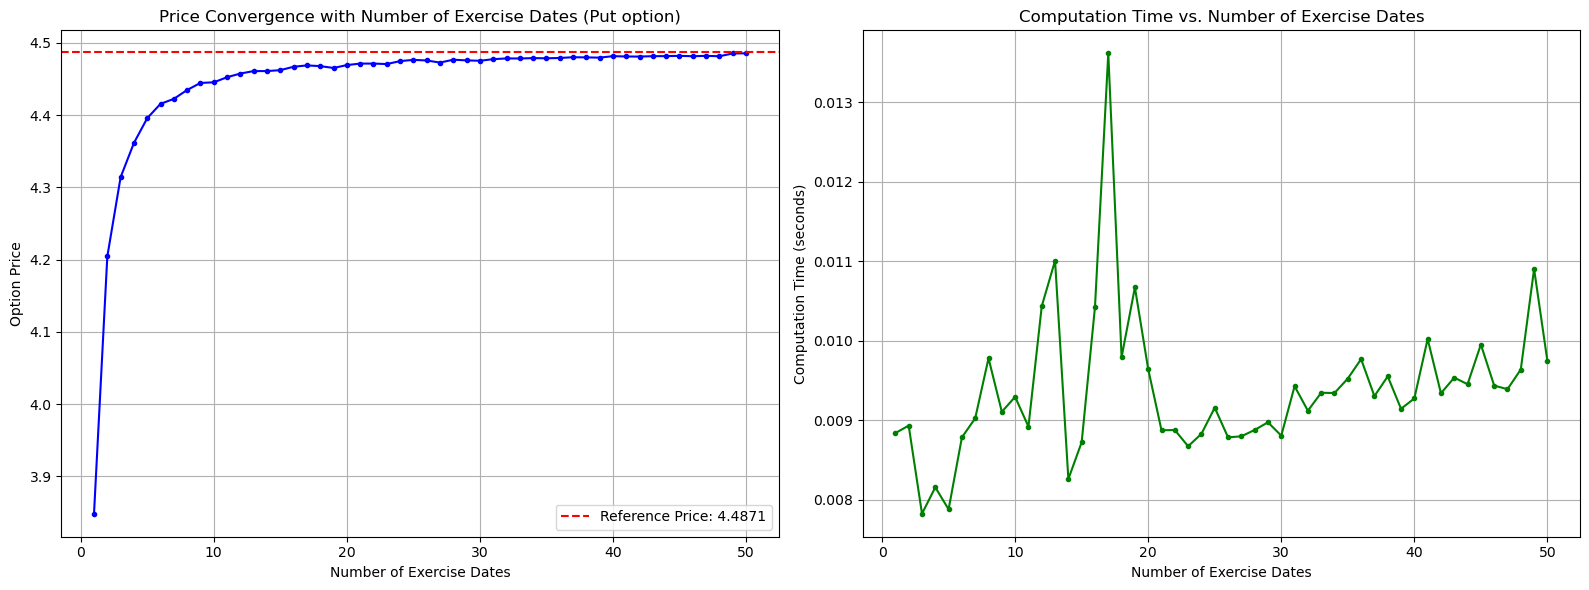

Minimum number of exercise dates needed for convergence: 49


Analyzing step convergence: 100%|██████████| 50/50 [00:03<00:00, 12.85it/s] 


In [10]:
# Example usage
bermudan_analyzer = BermudanExerciseDatesAnalyzer(
    S0=S0, K=K, r=r, sigma=sigma, T=T, steps=100
)

# Analyze how Bermudan price converges to American price with increasing exercise dates
dates_fig, dates, prices, _ = bermudan_analyzer.plot_exercise_dates_convergence(
    'put', min_dates=1, max_dates=50, date_increment=1, reference_price=american_price
)
plt.show()  # Show the plot
# Find the number of exercise dates needed for convergence
num_dates = bermudan_analyzer.find_dates_for_convergence(
    'put', tolerance=0.001, max_dates=200, date_increment=1
)
print(f"Minimum number of exercise dates needed for convergence: {num_dates}")

# We'll analyze step convergence for different numbers of exercise dates
exercise_dates_to_analyze = [1, 2, 4, 8, 12, 20, 50]  # Varying number of exercise dates
min_steps_required = []

for num_dates in exercise_dates_to_analyze:
    # Create equally spaced exercise dates
    exercise_dates = np.linspace(0, T, num_dates + 1)[1:]

    # Analyse step convergence for each set of exercise dates
    step_analyzer = ConvergenceAnalyzer(
        S0=S0, K=K, r=r, sigma=sigma, T=T
    )
    steps, _, _ = step_analyzer.analyze_step_convergence(
        'put', exercise_dates=exercise_dates, min_steps=10, max_steps=500, step_increment=10
    )
    #min_steps_required.append(min(steps))
    #print(f"Minimum steps required for {num_dates} exercise dates: {min_steps_required[-1]}")

# plt.figure(figsize=(10, 6))
# plt.plot(exercise_dates_to_analyze, min_steps_required, 'bo-', linewidth=2)
# plt.title('Minimum Steps Required vs. Number of Exercise Dates')
# plt.xlabel('Number of Exercise Dates')
# plt.ylabel('Minimum Steps Required (0.1% tolerance)')
# plt.grid(True)
# plt.savefig('min_steps_vs_exercise_dates.png')
# print("Minimum steps vs exercise dates plot saved.")


Detailed Bermudan Option Analysis (Quarterly Exercise)
----------------------------------------
Bermudan Put Option Price (Quarterly Exercise): 4.361419
American Put Option Price:                      4.487102
Price difference (American - Bermudan):         0.125683
Bermudan option exercise strategy plot saved.

Comparison of European, Bermudan, and American Options
----------------------------------------


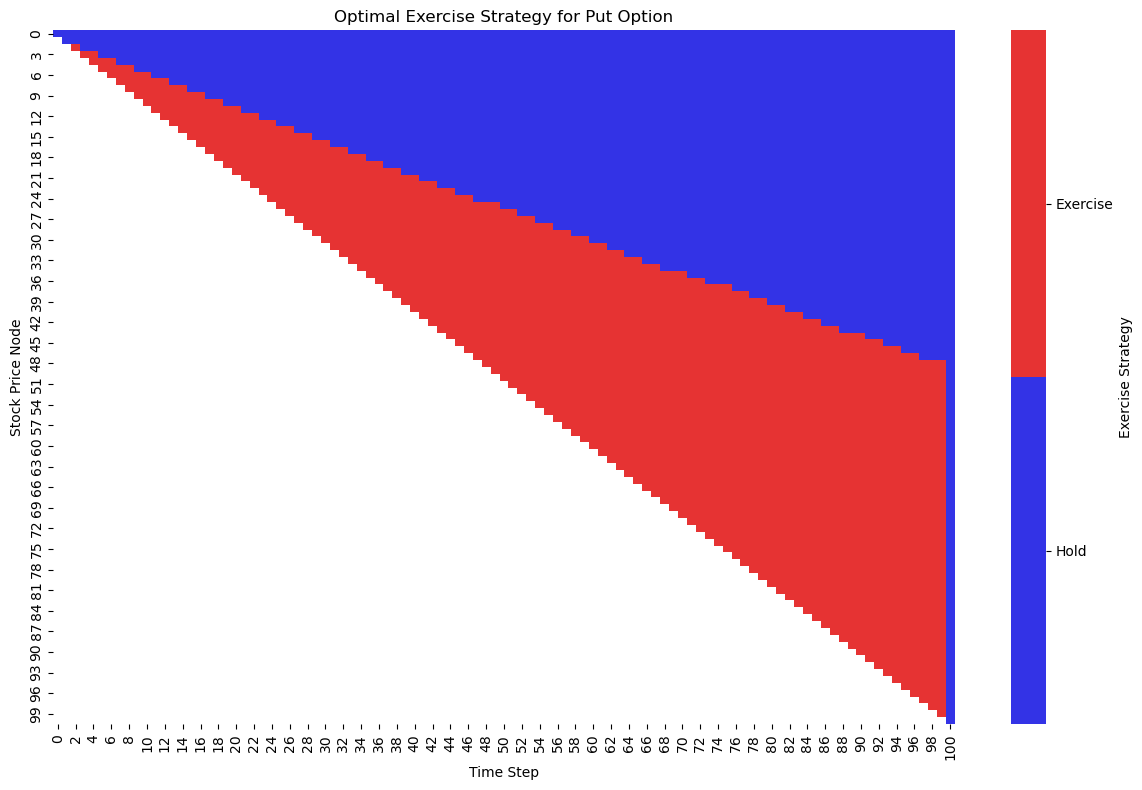

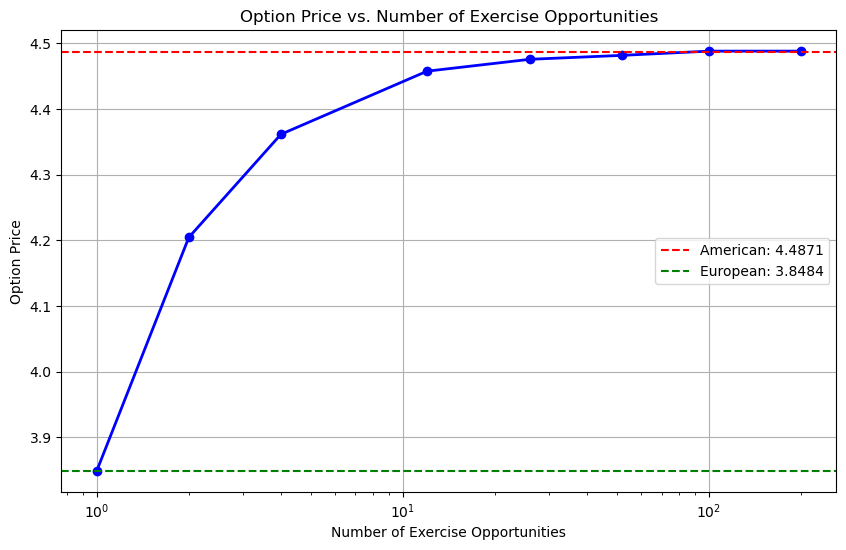

In [11]:
# 4. Detailed Analysis for a Specific Bermudan Option
print("\nDetailed Bermudan Option Analysis (Quarterly Exercise)")
print("-" * 40)

# Bermudan option with quarterly exercise dates
quarterly_dates = [0.25, 0.5, 0.75, 1.0]
bermudan_pricer = BinomialTreePricer(S0=S0, K=K, r=r, sigma=sigma, T=T, steps=100)
bermudan_price = bermudan_pricer.price_option('put', quarterly_dates)

print(f"Bermudan Put Option Price (Quarterly Exercise): {bermudan_price:.6f}")
print(f"American Put Option Price:                      {american_price:.6f}")
print(f"Price difference (American - Bermudan):         {american_price - bermudan_price:.6f}")

# Plot exercise strategy
bermudan_strategy_fig = bermudan_pricer.plot_exercise_strategy('put')
bermudan_strategy_fig.savefig('bermudan_exercise_strategy.png')
print("Bermudan option exercise strategy plot saved.")

# 5. Comparison of European, Bermudan with varying exercise dates, and American
print("\nComparison of European, Bermudan, and American Options")
print("-" * 40)

# Create a European option (exercise only at maturity)
european_pricer = BinomialTreePricer(S0=S0, K=K, r=r, sigma=sigma, T=T, steps=100)
european_price = european_pricer.price_option('put', [T])

# Bermudan options with different exercise frequencies
exercise_counts = [1, 2, 4, 12, 26, 52, 100, 200]  # Number of exercise opportunities
bermudan_prices = []

for count in exercise_counts:
    dates = np.linspace(0, T, count + 1)[1:]
    price = bermudan_pricer.price_option('put', dates)
    bermudan_prices.append(price)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(exercise_counts, bermudan_prices, 'bo-', linewidth=2)
plt.axhline(y=american_price, color='r', linestyle='--', label=f'American: {american_price:.4f}')
plt.axhline(y=european_price, color='g', linestyle='--', label=f'European: {european_price:.4f}')
plt.title('Option Price vs. Number of Exercise Opportunities')
plt.xlabel('Number of Exercise Opportunities')
plt.ylabel('Option Price')
plt.xscale('log')  # Log scale for x-axis
plt.grid(True)
plt.legend()

# American Option Pricing using Extrapolation Techniques


We approximate the American option price by pricing a series of Bermudan options, which only allow exercise at a finite set of discrete dates $\{t_1, t_2, ..., t_{N_e}\}$. As the number of exercise opportunities $N_e$ increases, the price of the Bermudan option $V(N_e)$ converges to the price of the American option $V_{\text{American}}$. Extrapolation techniques leverage this convergence to estimate $V_{\text{American}}$ by analyzing the relationship between $V(N_e)$ and $N_e$ (or $h=1/N_e$).

We will use the Binomial Tree method to compute the necessary Bermudan option prices $V(N_e)$.

## 1. Binomial Tree Method for Bermudan Options

The Binomial Tree model discretizes time into $N$ steps of size $\Delta t = T/N$. The underlying asset price $S$ is assumed to move up by a factor $u$ or down by a factor $d$ at each step, with risk-neutral probability $p$. Common choices for parameters (like Cox-Ross-Rubinstein) are:
$$ u = e^{\sigma \sqrt{\Delta t}}, \quad d = \frac{1}{u}, \quad p = \frac{e^{r \Delta t} - d}{u - d} $$
A tree of possible stock prices $S_{j,i}$ (price at step $i$, after $j$ down moves) is constructed.

To price a Bermudan option exercisable at dates corresponding to steps $k_1, k_2, ...$, we perform backward induction:
1.  **Maturity:** Calculate the option value at maturity ($i=N$) based on the payoff function (e.g., $V_{j,N} = \max(K - S_{j,N}, 0)$ for a put).
2.  **Backward Step:** For each step $i = N-1, ..., 0$:
    * Calculate the discounted expected value of *holding* the option (continuation value):
        $$ C_{j,i} = e^{-r \Delta t} \left( p V_{j, i+1} + (1-p) V_{j+1, i+1} \right) $$
    * Calculate the value of *immediate exercise* (intrinsic value):
        $$ P_{j,i} = \max(K - S_{j,i}, 0) \quad (\text{for a put}) $$
    * If step $i$ corresponds to an allowed exercise date:
        $$ V_{j,i} = \max(P_{j,i}, C_{j,i}) $$
    * If step $i$ is *not* an allowed exercise date:
        $$ V_{j,i} = C_{j,i} $$
3.  **Result:** The Bermudan option price is $V_{0,0}$.

For the extrapolation methods below, we typically set the number of tree steps equal to the number of exercise dates ($N=N_e$) and allow exercise at every step from $t=\Delta t$ to $t=T$.

## 2. Richardson Extrapolation

Richardson extrapolation is a technique to improve the accuracy of a numerical estimate by combining results obtained with different step sizes, assuming a known structure for the convergence error.

### Method:

For the Binomial Tree applied to American options, the price $V(N)$ computed with $N$ steps often converges to the true American price $V_{\text{American}}$ with an error that can be expanded in powers of $h = 1/N$:
$$ V(N) = V_{\text{American}} + \frac{c_1}{N} + \frac{c_2}{N^2} + O\left(\frac{1}{N^3}\right) $$
The leading error term is typically $O(1/N)$. Richardson extrapolation aims to eliminate this term.

We compute the price using $N$ steps, $V(N)$, and using twice the number of steps, $V(2N)$. Writing the error expansion for $V(2N)$:
$$ V(2N) = V_{\text{American}} + \frac{c_1}{2N} + \frac{c_2}{(2N)^2} + O\left(\frac{1}{N^3}\right) = V_{\text{American}} + \frac{c_1}{2N} + \frac{c_2}{4N^2} + O\left(\frac{1}{N^3}\right) $$

Consider the combination $2V(2N) - V(N)$:
$$ 2V(2N) - V(N) = 2\left(V_{\text{American}} + \frac{c_1}{2N} + \frac{c_2}{4N^2}\right) - \left(V_{\text{American}} + \frac{c_1}{N} + \frac{c_2}{N^2}\right) + O\left(\frac{1}{N^3}\right) $$
$$ = (2V_{\text{American}} - V_{\text{American}}) + \left(\frac{2c_1}{2N} - \frac{c_1}{N}\right) + \left(\frac{2c_2}{4N^2} - \frac{c_2}{N^2}\right) + O\left(\frac{1}{N^3}\right) $$
$$ = V_{\text{American}} + (c_1 - c_1)\frac{1}{N} + \left(\frac{c_2}{2} - c_2\right)\frac{1}{N^2} + O\left(\frac{1}{N^3}\right) $$
$$ = V_{\text{American}} - \frac{c_2}{2N^2} + O\left(\frac{1}{N^3}\right) $$

The $O(1/N)$ error term is eliminated, resulting in an estimate that converges faster, with error $O(1/N^2)$. The Richardson extrapolated estimate is:
$$ V_{\text{Richardson}} = 2 V(2N) - V(N) $$

We can compute this for increasing $N$ and observe the convergence.

## 3. Cubic Polynomial Extrapolation

This method fits a polynomial to the computed Bermudan prices $V(N_e)$ as a function of $h = 1/N_e$ and extrapolates to $h=0$ (which corresponds to $N_e \to \infty$).

### Method:

Assume the error expansion holds:
$$ V(N_e) = V(h) = V_{\text{American}} + a_1 h + a_2 h^2 + a_3 h^3 + O(h^4) $$
We compute $V(N_e)$ for a range of $N_e$ values (e.g., $N_e = 5, 10, ..., 200$). Let $h_i = 1/N_{e,i}$ and $y_i = V(N_{e,i})$.

We fit a cubic polynomial to these data points $(h_i, y_i)$:
$$ \hat{V}(h) = \beta_3 h^3 + \beta_2 h^2 + \beta_1 h + \beta_0 $$
The coefficients $(\beta_3, \beta_2, \beta_1, \beta_0)$ are determined using least-squares regression 
The cubic polynomial approximation $\hat{V}(h)$ matches the first few terms of the true error expansion. The extrapolated estimate for the American option price is the value of the polynomial at $h=0$:
$$ V_{\text{Cubic}} = \hat{V}(0) = \beta_0 $$
This constant term $\beta_0$ represents the estimated price when the step size $h$ goes to zero (infinite exercise opportunities).

## 4. Romberg Extrapolation

Romberg extrapolation is a systematic way to iteratively apply Richardson-like extrapolation to eliminate successively higher-order error terms. It generates a triangular table of estimates with increasing accuracy.

### Method:

Assume the error expansion for the Binomial Tree price $V(N)$ is:
$$ V(N) = V_{\text{American}} + \frac{c_1}{N} + \frac{c_2}{N^2} + \frac{c_3}{N^3} + \dots $$
We compute $V(N_k)$ for a sequence of steps $N_k = N_0 \cdot 2^k$ (e.g., $N_0=5$, giving $N=5, 10, 20, 40, ...$).

Let $R_{k, 0} = V(N_k)$ be the initial estimates (zeroth column of the Romberg table).

The first level of extrapolation (first column, $m=1$) eliminates the $O(1/N)$ term using the Richardson formula based on a factor of 2 refinement:
$$ R_{k, 1} = \frac{2^1 R_{k+1, 0} - R_{k, 0}}{2^1 - 1} = 2 R_{k+1, 0} - R_{k, 0} $$
This yields estimates with error $O(1/N^2)$.

The second level of extrapolation (second column, $m=2$) eliminates the $O(1/N^2)$ term using the estimates from the previous column, based on a factor of $2^2=4$:
$$ R_{k, 2} = \frac{2^2 R_{k+1, 1} - R_{k, 1}}{2^2 - 1} = \frac{4 R_{k+1, 1} - R_{k, 1}}{3} $$
This yields estimates with error $O(1/N^3)$.

The general Romberg formula for eliminating the $m$-th order term (assuming the error terms decrease appropriately) is:
$$ R_{k, m} = \frac{2^m R_{k+1, m-1} - R_{k, m-1}}{2^m - 1} $$
*(Note: Some sources use $4^m$ if the underlying method has error $O(h^{2m})$. For Binomial Trees with $O(1/N)$ leading error, the factor $2^m$ related to step count doubling is often appropriate for sequential term elimination).* The implementation often uses the $4^j$ factor, assuming the Richardson step produces $O(1/N^2)$ error and subsequent steps eliminate $O(1/N^4)$, etc., which works well in practice. Let's denote the formula used in the code:
$$ R_{i, j} = \frac{4^j R_{i+1, j-1} - R_{i, j-1}}{4^j - 1} \quad (\text{Code Implementation Formula}) $$
This formula assumes that after the first Richardson step (which eliminates $O(h)$), the remaining error expansion is in powers of $h^2$.

The Romberg table is built column by column. The diagonal elements $R_{0, m}$ represent estimates with increasing orders of accuracy. The best estimate is typically the last computed value in the first row, $R_{0, M_{max}}$.

---

--- American Option Pricing via Extrapolation ---

Parameters:
S0=36.0, K=40.0, r=0.06, sigma=0.2, T=1.0, Type=put

--- Richardson Extrapolation ---
Bermudan Price (N=100): 4.488050
Bermudan Price (N=200): 4.487102
Richardson Extrapolated American Price: 4.486154


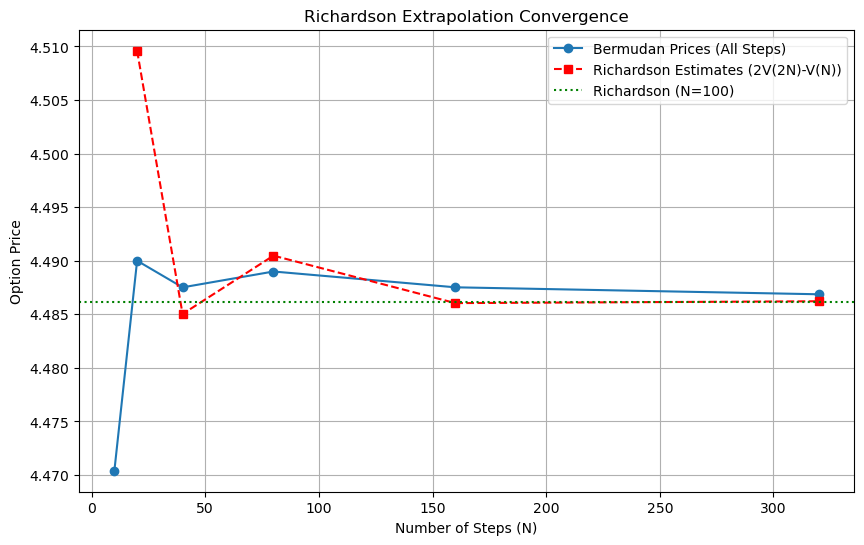


--- Cubic Polynomial Extrapolation ---
Calculating Bermudan prices for N = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]...
Cubic Extrapolated American Price: 4.488073


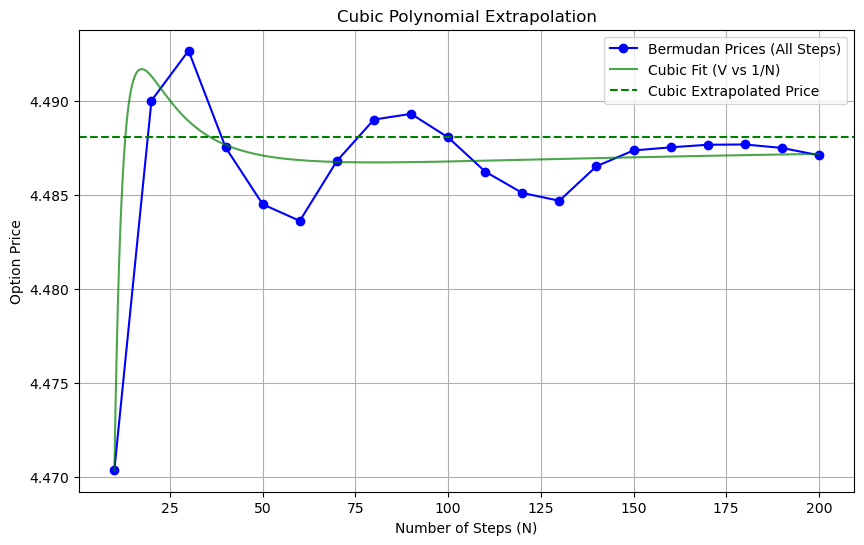


--- Romberg Extrapolation ---
Calculating Bermudan prices for N = [10, 20, 40, 80, 160, 320]...

Romberg Table R[i, j]:
       Order 0  Order 1  Order 2  Order 3  Order 4  Order 5
N=10  4.470402 4.496537 4.486031 4.489735 4.486810 4.486624
N=20  4.490003 4.486687 4.489677 4.486822 4.486624      NaN
N=40  4.487516 4.489490 4.486867 4.486625      NaN      NaN
N=80  4.488997 4.487031 4.486629      NaN      NaN      NaN
N=160 4.487522 4.486654      NaN      NaN      NaN      NaN
N=320 4.486871      NaN      NaN      NaN      NaN      NaN

Romberg Extrapolated American Price: 4.486624


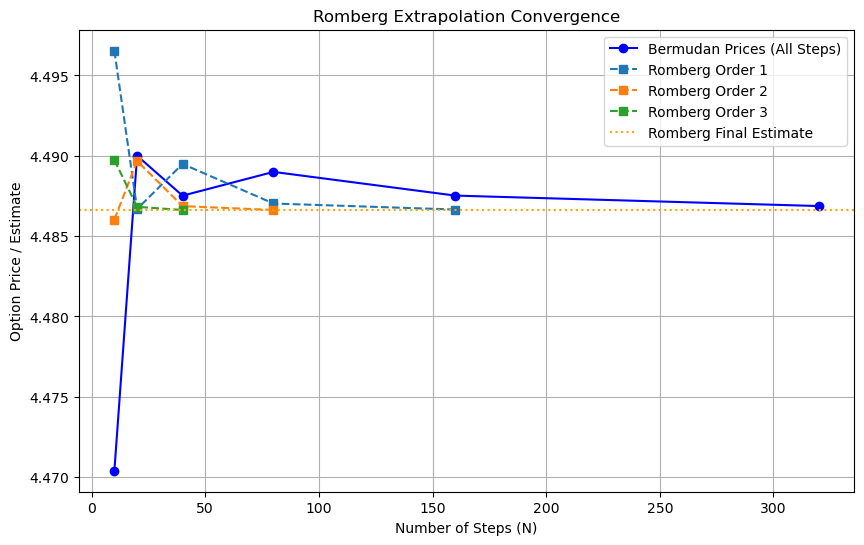


--- Summary of American Put Price Estimates ---
Richardson Extrapolation (N=100): 4.486154
Cubic Polynomial Extrapolation:      4.488073
Romberg Extrapolation:               4.486624


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # For Romberg table display

print("--- American Option Pricing via Extrapolation ---")

# --- 0. Parameters ---
S0 = 36.0
K = 40.0
r = 0.06
sigma = 0.2
T = 1.0
option_type = 'put' # Ensure consistency

print("\nParameters:")
print(f"S0={S0}, K={K}, r={r}, sigma={sigma}, T={T}, Type={option_type}")

# --- 1. Binomial Tree Pricer Class ---
class BinomialTreePricer:
    """
    Prices European or Bermudan options using the Cox-Ross-Rubinstein Binomial Tree.
    For American option approximation via extrapolation, set exercise_dates to all steps.
    """
    def __init__(self, S0, K, r, sigma, T, steps):
        if steps <= 0:
             raise ValueError("Number of steps must be positive.")
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.steps = steps
        self.dt = T / steps
        
        # CRR parameters
        self.u = np.exp(sigma * np.sqrt(self.dt))
        self.d = 1.0 / self.u
        if self.u == self.d:
             raise ValueError("u and d are equal, check parameters.")
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)
        
        # Parameter checks
        if not (0 < self.p < 1):
             print(f"Warning: Risk-neutral probability p={self.p:.4f} is outside (0, 1) for N={steps}. May indicate instability.")
             # Clamp p for stability, though this deviates from pure CRR
             # self.p = max(min(self.p, 0.9999), 0.0001)


    def price_option(self, option_type='put', exercise_type='bermudan', exercise_dates=None):
        """
        Prices the option.
        exercise_type: 'bermudan' or 'european'
        exercise_dates: List/array of times (in years) when exercise is allowed for Bermudan.
                        If None for Bermudan, defaults to exercise at all steps (American approximation).
        """
        N = self.steps
        
        # Build stock price tree
        stock_tree = np.zeros((N + 1, N + 1))
        for i in range(N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)

        # Initialize option values at maturity
        option_tree = np.zeros_like(stock_tree)
        if option_type == 'put':
            option_tree[:, N] = np.maximum(self.K - stock_tree[:, N], 0)
        elif option_type == 'call':
            option_tree[:, N] = np.maximum(stock_tree[:, N] - self.K, 0)
        else:
            raise ValueError("option_type must be 'put' or 'call'")

        # Determine exercise steps indices
        if exercise_type == 'bermudan':
            if exercise_dates is None:
                # Default Bermudan to exercise at all steps (American approximation)
                 exercise_indices = set(range(N + 1)) # Exercise possible at all steps 0 to N
            else:
                 # Convert exercise dates (in years) to step indices
                 # Ensure indices are within valid range [0, N]
                 exercise_indices = set(np.round(np.array(exercise_dates) / self.dt).astype(int))
                 exercise_indices = {idx for idx in exercise_indices if 0 <= idx <= N}
        elif exercise_type == 'european':
            exercise_indices = set() # No early exercise allowed
        else:
            raise ValueError("exercise_type must be 'bermudan' or 'european'")

        # Backward induction
        discount = np.exp(-self.r * self.dt)
        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                # Calculate continuation value (value if held)
                cont_value = discount * (
                    self.p * option_tree[j, i + 1] + (1 - self.p) * option_tree[j + 1, i + 1]
                )

                if exercise_type == 'bermudan' and i in exercise_indices:
                    # Calculate intrinsic value (value if exercised now)
                    if option_type == 'put':
                        intrinsic_value = np.maximum(self.K - stock_tree[j, i], 0)
                    else: # call
                        intrinsic_value = np.maximum(stock_tree[j, i] - self.K, 0)
                    # Choose the max of exercising or holding
                    option_tree[j, i] = max(intrinsic_value, cont_value)
                else:
                    # If not an exercise date or European option, value is continuation value
                    option_tree[j, i] = cont_value

        return option_tree[0, 0]

# --- Helper function to get Bermudan price (exercise at all steps) ---
def get_bermudan_price_all_steps(N_steps):
     """ Calculates Bermudan price allowing exercise at all steps """
     if N_steps < 1: return np.nan # Need at least 1 step
     pricer = BinomialTreePricer(S0, K, r, sigma, T, steps=N_steps)
     # Pass exercise_dates=None to allow exercise at all steps
     price = pricer.price_option(option_type=option_type, exercise_type='bermudan', exercise_dates=None)
     return price

# --- 2. Richardson Extrapolation ---
print("\n--- Richardson Extrapolation ---")
N_richardson = 100 # Base number of steps
V_N = get_bermudan_price_all_steps(N_richardson)
V_2N = get_bermudan_price_all_steps(2 * N_richardson)

if np.isnan(V_N) or np.isnan(V_2N):
     print("Could not compute base prices for Richardson.")
     V_american_richardson = np.nan
else:
     V_american_richardson = 2 * V_2N - V_N
     print(f"Bermudan Price (N={N_richardson}): {V_N:.6f}")
     print(f"Bermudan Price (N={2*N_richardson}): {V_2N:.6f}")
     print(f"Richardson Extrapolated American Price: {V_american_richardson:.6f}")

# Plotting Richardson Convergence
N_values_plot_rich = [10, 20, 40, 80, 160, 320] # Use doubling sequence for plot
bermudan_prices_plot_rich = [get_bermudan_price_all_steps(n) for n in N_values_plot_rich]
richardson_estimates_plot = []
for i in range(len(N_values_plot_rich) - 1):
     v1 = bermudan_prices_plot_rich[i]
     v2 = bermudan_prices_plot_rich[i+1]
     if not np.isnan(v1) and not np.isnan(v2):
         richardson_estimates_plot.append(2*v2 - v1)
     else:
         richardson_estimates_plot.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(N_values_plot_rich, bermudan_prices_plot_rich, 'o-', label='Bermudan Prices (All Steps)')
if len(richardson_estimates_plot) > 0:
    plt.plot(N_values_plot_rich[1:], richardson_estimates_plot, 's--', color='red', label='Richardson Estimates (2V(2N)-V(N))')
if not np.isnan(V_american_richardson):
     plt.axhline(y=V_american_richardson, color='g', linestyle=':', label=f'Richardson (N={N_richardson})')

plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('Richardson Extrapolation Convergence')
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Cubic Polynomial Extrapolation ---
print("\n--- Cubic Polynomial Extrapolation ---")
# N_e values from 10 up to 200, increasing step size
exercise_counts_cubic = list(range(10, 201, 10))
bermudan_prices_cubic = []
print(f"Calculating Bermudan prices for N = {exercise_counts_cubic}...")
for N_e in exercise_counts_cubic:
    price = get_bermudan_price_all_steps(N_e)
    bermudan_prices_cubic.append(price)

# Filter out any NaN results if steps were too small for stable p
valid_indices_cubic = [i for i, p in enumerate(bermudan_prices_cubic) if not np.isnan(p)]
if len(valid_indices_cubic) < 4: # Need at least 4 points for cubic fit
    print("Not enough valid prices for cubic extrapolation.")
    V_american_cubic = np.nan
else:
    valid_counts = np.array(exercise_counts_cubic)[valid_indices_cubic]
    valid_prices = np.array(bermudan_prices_cubic)[valid_indices_cubic]

    # Perform fit using h = 1/N
    h_cubic = 1.0 / valid_counts
    coeffs_cubic = np.polyfit(h_cubic, valid_prices, 3) # Fit V(h) = a*h^3 + b*h^2 + c*h + d
    V_american_cubic = coeffs_cubic[-1] # Extrapolated value is the constant term d = V(h=0)
    print(f"Cubic Extrapolated American Price: {V_american_cubic:.6f}")

    # Plotting Cubic Extrapolation
    plt.figure(figsize=(10, 6))
    plt.plot(valid_counts, valid_prices, 'bo-', label='Bermudan Prices (All Steps)')

    # Generate smooth curve for the polynomial fit vs N
    h_fit = np.linspace(min(h_cubic), max(h_cubic), 200)
    # Avoid division by zero if h_fit includes 0
    h_fit = h_fit[h_fit > 1e-10] # Only plot where N is finite
    N_fit = 1.0 / h_fit
    V_fit = np.polyval(coeffs_cubic, h_fit)
    plt.plot(N_fit, V_fit, 'g-', alpha=0.7, label='Cubic Fit (V vs 1/N)')

    plt.axhline(y=V_american_cubic, color='green', linestyle='--', label=f'Cubic Extrapolated Price')
    plt.xlabel('Number of Steps (N)')
    plt.ylabel('Option Price')
    plt.title('Cubic Polynomial Extrapolation')
    plt.legend()
    plt.grid(True)
    # Optional: Set xlim to focus on larger N
    # plt.xlim(left=min(valid_counts))
    plt.show()


# --- 4. Romberg Extrapolation ---
print("\n--- Romberg Extrapolation ---")
# Use geometrically increasing N_e, e.g., N*2^k
N_romberg_base = 10 # Start with N=10
num_romberg_levels = 6 # Number of levels (e.g., 6 => N=10, 20, 40, 80, 160, 320)
exercise_counts_romberg = [N_romberg_base * (2**k) for k in range(num_romberg_levels)]
bermudan_prices_romberg = []

print(f"Calculating Bermudan prices for N = {exercise_counts_romberg}...")
for N_e in exercise_counts_romberg:
    price = get_bermudan_price_all_steps(N_e)
    bermudan_prices_romberg.append(price)

# Check for NaN results
if np.isnan(bermudan_prices_romberg).any():
    print("Warning: NaN encountered in Bermudan prices for Romberg. Extrapolation may fail.")
    V_american_romberg = np.nan
    R_table = None
else:
    # Build Romberg table R[level, order]
    num_levels = len(bermudan_prices_romberg)
    R_table = np.zeros((num_levels, num_levels)) * np.nan # Initialize with NaN

    # Fill first column (R_{k,0}) with computed prices
    for k in range(num_levels):
        R_table[k, 0] = bermudan_prices_romberg[k]

    # Apply Romberg formula iteratively
    # Using R[i, j] = (4^j * R[i+1, j-1] - R[i, j-1]) / (4^j - 1)
    # Note: indices map to theory R_{k,m} differently. Here R[row, col]
    # row `i` corresponds to N = N_base * 2^i
    # col `j` corresponds to order of extrapolation
    for j in range(1, num_levels): # Column index (order of extrapolation)
        for i in range(num_levels - j): # Row index
            if np.isnan(R_table[i, j-1]) or np.isnan(R_table[i+1, j-1]):
                continue # Cannot compute if previous values are NaN
            # Formula assumes O(h^2) convergence after first step
            power_of_4 = 4**j
            R_table[i, j] = (power_of_4 * R_table[i + 1, j - 1] - R_table[i, j - 1]) / (power_of_4 - 1)

    V_american_romberg = R_table[0, num_levels - 1] # Top-right element is best estimate
    print("\nRomberg Table R[i, j]:")
    # Display using pandas for better formatting
    df_R = pd.DataFrame(R_table)
    df_R.index = [f"N={N_romberg_base*2**i}" for i in range(num_levels)]
    df_R.columns = [f"Order {j}" for j in range(num_levels)]
    print(df_R.to_string(float_format="%.6f"))
    print(f"\nRomberg Extrapolated American Price: {V_american_romberg:.6f}")

    # Plotting Romberg Convergence
    plt.figure(figsize=(10, 6))
    plt.plot(exercise_counts_romberg, bermudan_prices_romberg, 'bo-', label='Bermudan Prices (All Steps)')

    # Plot estimates from different Romberg orders (columns)
    orders_to_plot = min(3, num_levels-1) # Plot first few orders + final
    for j in range(1, orders_to_plot + 1):
         # Need N values corresponding to R[0,j], R[1,j] ...
         valid_romberg_indices = np.arange(num_levels - j)
         n_values_for_order_j = [N_romberg_base * (2**k) for k in valid_romberg_indices]
         plt.plot(n_values_for_order_j, R_table[valid_romberg_indices, j], marker='s', linestyle='--', label=f'Romberg Order {j}')

    plt.axhline(y=V_american_romberg, color='orange', linestyle=':', label=f'Romberg Final Estimate')
    plt.xlabel('Number of Steps (N)')
    plt.ylabel('Option Price / Estimate')
    plt.title('Romberg Extrapolation Convergence')
    # plt.xscale('log', base=2) # Optional log scale for N
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Summary of American Put Price Estimates ---")
print(f"Richardson Extrapolation (N={N_richardson}): {V_american_richardson:.6f}")
print(f"Cubic Polynomial Extrapolation:      {V_american_cubic:.6f}")
print(f"Romberg Extrapolation:               {V_american_romberg:.6f}")

## Theoretical Explanation of the American Put Option Pricing using Finite Difference Method (FDM) with Projected Successive Over-Relaxation (PSOR)

( included in the report)

American Put Option Price: $21.8190
Comparable European Put Price: $3.8443


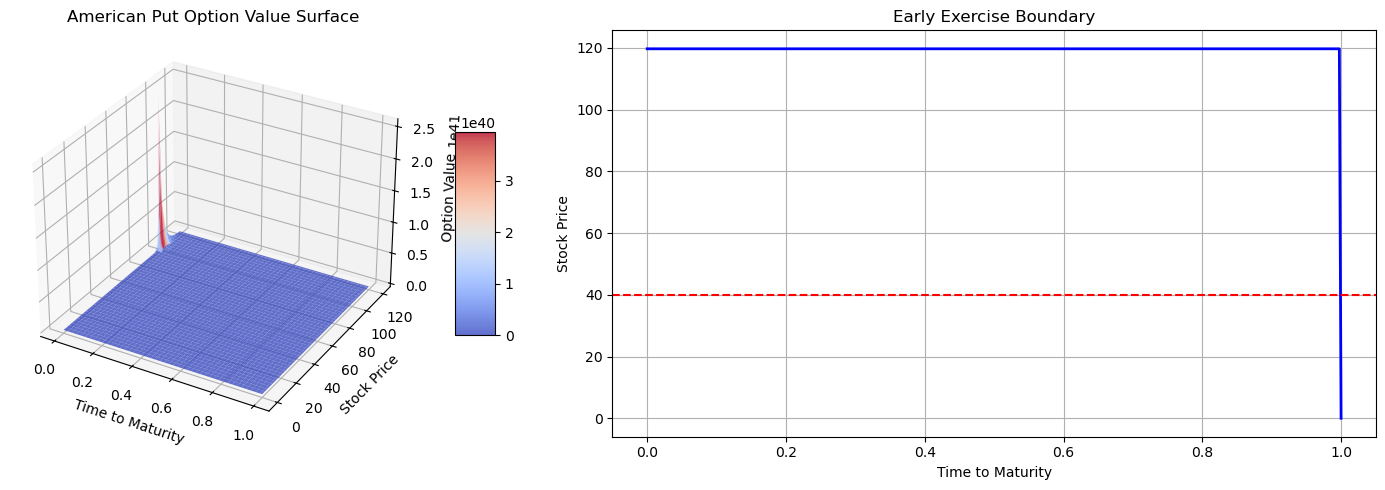

Grid size 50x50: $7.205611
Grid size 100x100: $10.615284
Grid size 200x200: $15.768842
Grid size 400x400: $21.819036


KeyboardInterrupt: 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def american_put_fdm(S0=36, K=40, r=0.06, sigma=0.2, T=1, N=400, M=400, S_max=120, omega=0.5, tol=1e-4, max_iter=400):
    """
    Price an American put option using finite difference method with Projected SOR
    
    Parameters:
    S0: Initial stock price
    K: Strike price
    r: Risk-free interest rate
    sigma: Volatility
    T: Time to maturity in years
    N: Number of time steps
    M: Number of stock price steps
    S_max: Maximum stock price
    omega: Relaxation parameter (1 < omega < 2)
    tol: Convergence tolerance
    max_iter: Maximum PSOR iterations
    
    Returns:
    option_price: Price of the American put option
    exercise_boundary: Early exercise boundary
    """
    # Create grid
    dt = T / N
    dS = S_max / M
    
    # Initialize arrays
    S = np.linspace(0, S_max, M+1)
    V = np.zeros((N+1, M+1))
    exercise_boundary = np.zeros(N+1)
    
    # Terminal condition (payoff at maturity)
    V[N,:] = np.maximum(K - S, 0)
    
    # Create coefficient matrices for the tridiagonal system
    alpha = np.zeros(M+1)
    beta = np.zeros(M+1)
    gamma = np.zeros(M+1)
    
    for i in range(1, M):
        alpha[i] = -dt/4 * (sigma**2 * S[i]**2 / dS**2 - r * S[i] / dS)
        beta[i] = 1 + dt/2 * (sigma**2 * S[i]**2 / dS**2 + r)
        gamma[i] = -dt/4 * (sigma**2 * S[i]**2 / dS**2 + r * S[i] / dS)
    
    # Complementary coefficients for time level n
    alpha_comp = np.zeros(M+1)
    beta_comp = np.zeros(M+1)
    gamma_comp = np.zeros(M+1)
    
    for i in range(1, M):
        alpha_comp[i] = dt/4 * (sigma**2 * S[i]**2 / dS**2 - r * S[i] / dS)
        beta_comp[i] = 1 - dt/2 * (sigma**2 * S[i]**2 / dS**2 + r)
        gamma_comp[i] = dt/4 * (sigma**2 * S[i]**2 / dS**2 + r * S[i] / dS)
    
    # Backward in time
    for n in range(N-1, -1, -1):
        # Set boundary conditions
        V[n,0] = K * np.exp(-r * (T - n*dt))
        V[n,M] = 0
        
        # Calculate right-hand side vector (b)
        b = np.zeros(M+1)
        for i in range(1, M):
            b[i] = alpha_comp[i] * V[n+1,i-1] + beta_comp[i] * V[n+1,i] + gamma_comp[i] * V[n+1,i+1]
        
        # Initialize solution for PSOR with previous time step
        V_new = np.copy(V[n+1,1:M])
        
        # PSOR iteration
        for k in range(max_iter):
            V_prev = np.copy(V_new)
            
            # First point (i=1) - special case
            i = 1
            temp = (b[i] - gamma[i] * V_prev[i]) / beta[i]  # No alpha[i]*V_new[i-2] term for i=1
            V_new[i-1] = (1 - omega) * V_prev[i-1] + omega * temp
            V_new[i-1] = max(V_new[i-1], K - S[i])
            
            # Inner points
            for i in range(2, M):
                temp = (b[i] - alpha[i] * V_new[i-2] - gamma[i] * V_prev[i-1]) / beta[i]
                V_new[i-1] = (1 - omega) * V_prev[i-1] + omega * temp
                V_new[i-1] = max(V_new[i-1], K - S[i])
            
            # Check convergence
            if np.max(np.abs(V_new - V_prev)) < tol:
                break
        
        # Save results
        V[n,1:M] = V_new
        
        # Determine exercise boundary
        exercise_boundary[n] = K  # Default value if no crossing found
        for i in range(M-1, 0, -1):
            if V[n,i] > K - S[i]:
                # Linear interpolation to find more accurate boundary
                if i < M-1:
                    numerator = (K - S[i]) - V[n,i]
                    denominator = (V[n,i+1] - (K - S[i+1])) + ((K - S[i]) - V[n,i])
                    if abs(denominator) > 1e-10:  # Avoid division by zero
                        exercise_boundary[n] = S[i] + (S[i+1] - S[i]) * (numerator / denominator)
                    else:
                        exercise_boundary[n] = S[i]
                else:
                    exercise_boundary[n] = S[i]
                break
    
    # Interpolate to find option value at S0
    idx = min(int(S0 / dS), M-1)
    option_price = V[0,idx] + (V[0,idx+1] - V[0,idx]) * (S0 - S[idx]) / dS
    
    return option_price, V, exercise_boundary, S

def plot_results(V, S, exercise_boundary, S0, K, T):
    """Plot option surface and exercise boundary"""
    N = V.shape[0] - 1
    M = V.shape[1] - 1
    
    fig = plt.figure(figsize=(16, 5))
    
    # Plot option value surface
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(np.linspace(0, T, N+1), S)
    surf = ax1.plot_surface(X, Y, V.T, cmap=cm.coolwarm, antialiased=True, alpha=0.8)
    ax1.set_title('American Put Option Value Surface')
    ax1.set_xlabel('Time to Maturity')
    ax1.set_ylabel('Stock Price')
    ax1.set_zlabel('Option Value')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # Mark S0 with a vertical line
    ax1.plot([0, 0], [S0, S0], [0, V[0, int(S0 / (S[-1] / M))]], 'r-', linewidth=2)
    
    # Plot exercise boundary
    ax2 = fig.add_subplot(122)
    time_grid = np.linspace(0, T, N+1)
    ax2.plot(time_grid, exercise_boundary, 'b-', linewidth=2)
    ax2.set_title('Early Exercise Boundary')
    ax2.set_xlabel('Time to Maturity')
    ax2.set_ylabel('Stock Price')
    ax2.grid(True)
    ax2.axhline(y=K, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.savefig('american_put_fdm.png', dpi=300)
    plt.show()

def main():
    # Parameters from the report
    S0 = 36
    K = 40
    r = 0.06
    sigma = 0.2
    T = 1
    N = 400
    M = 400
    S_max = 120
    omega = 0.5
    
    # Price the option
    price, V, exercise_boundary, S = american_put_fdm(S0, K, r, sigma, T, N, M, S_max, omega)
    
    print(f"American Put Option Price: ${price:.4f}")
    print(f"Comparable European Put Price: ${european_put(S0, K, r, sigma, T):.4f}")
    
    # Plot results
    plot_results(V, S, exercise_boundary, S0, K, T)
    
    # Convergence analysis
    grid_sizes = [50, 100, 200, 400, 800]
    prices = []
    
    for size in grid_sizes:
        price, _, _, _ = american_put_fdm(S0, K, r, sigma, T, size, size, S_max, omega)
        prices.append(price)
        print(f"Grid size {size}x{size}: ${price:.6f}")
    
    # Plot convergence
    plt.figure(figsize=(8, 5))
    plt.plot(grid_sizes, prices, 'bo-')
    plt.title('Price Convergence with Grid Refinement')
    plt.xlabel('Grid Size (N=M)')
    plt.ylabel('Option Price')
    plt.grid(True)
    plt.savefig('convergence.png', dpi=300)
    plt.show()

def european_put(S0, K, r, sigma, T):
    """Black-Scholes formula for European put"""
    from scipy.stats import norm
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

if __name__ == "__main__":
    main()